#  Project Name: Time Series Analysis and Modeling

#### Build time series model based on historical housing price from Zillow and find the top 5 best zip codes to invest in

Name: Bonnie Ma<br/>

https://github.com/bonniema

# Overview
<br>[Background and KPI](#001)
<br>[Step1: Load Data & Import Libraries](#002)
<br>[Step2: Data Processing](#003)
<br>[Step3: Data Exploration and Visualization](#004)
<br>[Step4: Initial ARIMA Models on Sample Zip Codes](#005)
<br>[Step5: Run SARIMA models on all Zipcodes](#006)
<br>[Step 6: Interpret the Results](#007)

# Background
<a id='001'></a>

This project assumes to be an investment firm based in New York City to provide detailed analysis and insights to investors who are interested in real estate for financial growth. Our target clients are mid-income families or individuals with initial budget under 500K and are looking to buy in 2020. 

The areas we will be focusing on is Manhattan and Brooklyn zipcodes with average house price under 3 Million in 2016-2018. 

#### Project KPI: 5 Yr ROI ((House Price of Year 5 - Buy Price) / Buy Price)

## Step 1: Load the Data/Import Libraries
<a id='002'></a>

In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter("ignore")

import itertools
import pandas as pd
import numpy as np

#for modeling
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose as sd
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LassoLarsCV

#for visualizations
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib.pylab import rcParams
import time

In [3]:
df = pd.read_csv('zillow_data.csv')
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [4]:
ny=df[(df['City']=='New York')]

In [5]:
area = pd.read_csv('manhattan_brooklyn_zip.csv')
area.head()

,RegionName,District
0,10001,Manhattan
1,10002,Manhattan
2,10003,Manhattan
3,10004,Manhattan
4,10005,Manhattan


In [6]:
ny1 = pd.merge(ny, area, how='left', on='RegionName')

In [7]:
ny2 = ny1[ny1['District'].notnull()]
ny2.groupby('District').count()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
District,,,,,,,,,,,,,,,,,,,,,
Brooklyn,29,29,29,29,29,29,29,25,25,25,...,29,29,29,29,29,29,29,29,29,29
Manhattan,4,4,4,4,4,4,4,1,1,1,...,4,4,4,4,4,4,4,4,4,4


Only 4 zipcodes in Manhattan are present in the database. We will focus on Brooklyn then. 

In [8]:
ny3 = ny2[ny2['District']=='Brooklyn']
ny3.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,District
1,62037,11226,New York,NY,New York,Kings,11,162000.0,162300.0,162600.0,...,851000,853900,870000,885100,887800,890500,901700,930700,963200,Brooklyn
3,62045,11235,New York,NY,New York,Kings,14,190500.0,191000.0,191500.0,...,777300,788800,793900,796000,799700,806600,810600,813400,816200,Brooklyn
9,62040,11230,New York,NY,New York,Kings,48,230100.0,230800.0,231500.0,...,1082700,1082800,1084900,1091200,1102400,1120200,1141600,1170000,1195400,Brooklyn
10,62020,11209,New York,NY,New York,Kings,50,255700.0,256600.0,257300.0,...,1013400,1019500,1024400,1024900,1018900,1023500,1029200,1023000,1015800,Brooklyn
11,62023,11212,New York,NY,New York,Kings,54,125000.0,125000.0,125000.0,...,387000,394600,401500,407900,414900,422300,426300,427100,428400,Brooklyn


In [9]:
ny4 = ny3.drop(['RegionID','City','State','Metro','CountyName','SizeRank','District'], axis ='columns')

In [10]:
ny4.head()

,RegionName,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
1,11226,162000.0,162300.0,162600.0,163000.0,163400.0,164000.0,164700.0,165700.0,166800.0,...,860200,851000,853900,870000,885100,887800,890500,901700,930700,963200
3,11235,190500.0,191000.0,191500.0,192000.0,192500.0,193000.0,193600.0,194300.0,195300.0,...,767300,777300,788800,793900,796000,799700,806600,810600,813400,816200
9,11230,230100.0,230800.0,231500.0,232100.0,232800.0,233600.0,234700.0,235900.0,237500.0,...,1079200,1082700,1082800,1084900,1091200,1102400,1120200,1141600,1170000,1195400
10,11209,255700.0,256600.0,257300.0,258100.0,258900.0,259800.0,260900.0,262000.0,263600.0,...,1005000,1013400,1019500,1024400,1024900,1018900,1023500,1029200,1023000,1015800
11,11212,125000.0,125000.0,125000.0,125000.0,125100.0,125100.0,125000.0,124800.0,124600.0,...,380000,387000,394600,401500,407900,414900,422300,426300,427100,428400


## Step 2: Reshape from Wide to Long Format & Data Processing
<a id='003'></a>

In [11]:
def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionName'], var_name='Month', value_name = 'MeanValue')
    melted['Month'] = pd.to_datetime(melted['Month'], format = '%Y-%m')
    melted = melted.dropna(subset=['MeanValue'])
    return melted

In [12]:
dfm = melt_data(ny4)

In [13]:
dfm.head()

,RegionName,Month,MeanValue
0,11226,1996-04-01,162000.0
1,11235,1996-04-01,190500.0
2,11230,1996-04-01,230100.0
3,11209,1996-04-01,255700.0
4,11212,1996-04-01,125000.0


In [14]:
dfm.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7313 entries, 0 to 7684
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   RegionName  7313 non-null   int64         
 1   Month       7313 non-null   datetime64[ns]
 2   MeanValue   7313 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 228.5 KB


In [15]:
dfm.set_index('Month', inplace = True)

In [16]:
dfm.head(10)

,RegionName,MeanValue
Month,,
1996-04-01,11226,162000.0
1996-04-01,11235,190500.0
1996-04-01,11230,230100.0
1996-04-01,11209,255700.0
1996-04-01,11212,125000.0
1996-04-01,11214,191000.0
1996-04-01,11221,133700.0
1996-04-01,11229,183900.0
1996-04-01,11234,172300.0


## Step 3: EDA and Visualization
<a id='004'></a>

First let's look at the overall trend of house prices overtime.

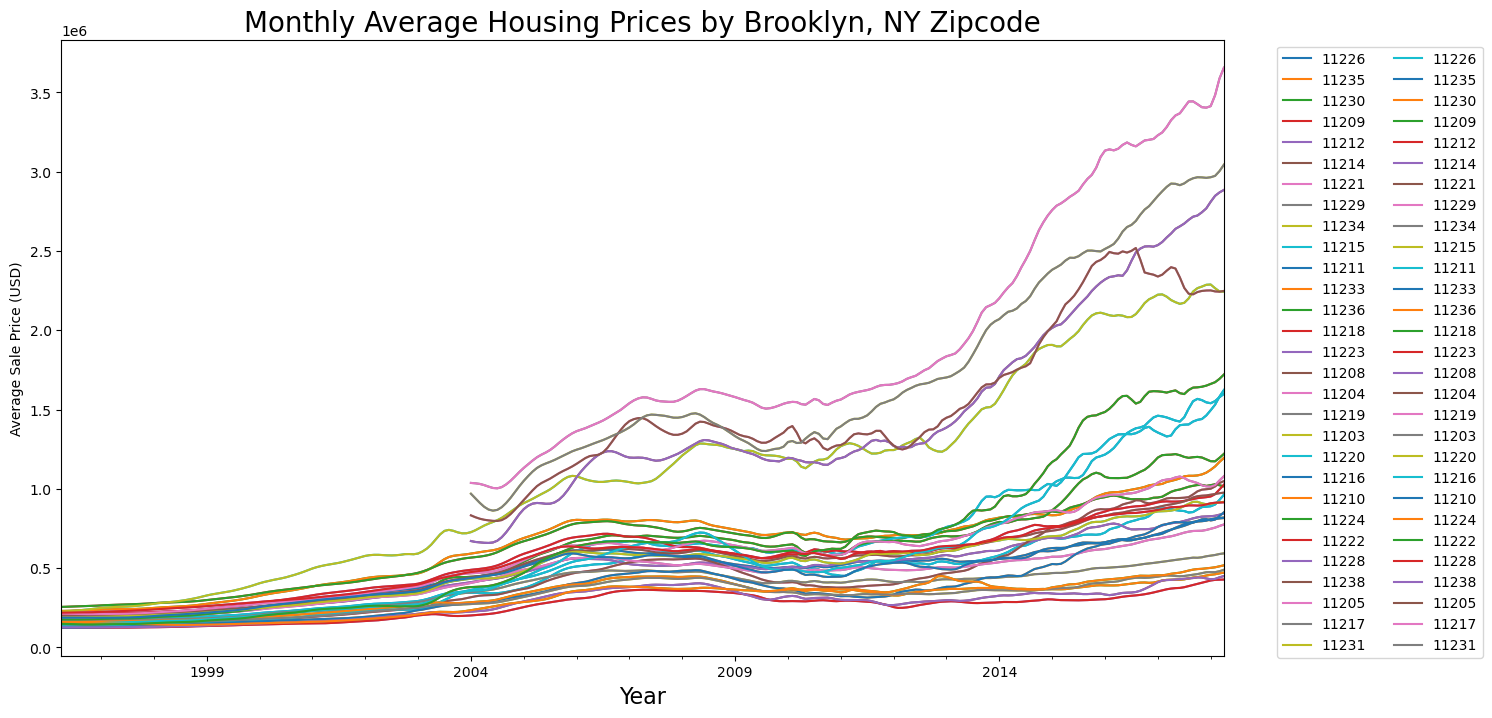

In [35]:
for zipcode in dfm.RegionName.unique():
    temp_df = dfm[dfm.RegionName == zipcode]
    temp_df['MeanValue'].plot(figsize = (15,8), label=zipcode)

plt.legend(bbox_to_anchor=(1.04,1), loc='upper left', ncol=2)
plt.xlabel("Year", fontsize = 16)
plt.ylabel("Average Sale Price (USD)")
plt.title('Monthly Average Housing Prices by Brooklyn, NY Zipcode', fontsize = 20);
plt.show()

### Observations of the data:
- 25 zip codes have data from 1996 to 2018, however, 4 zip codes do not
- There was a dip in 2008 and 2010 because of the financial crisis, housing price became stable around 2011.

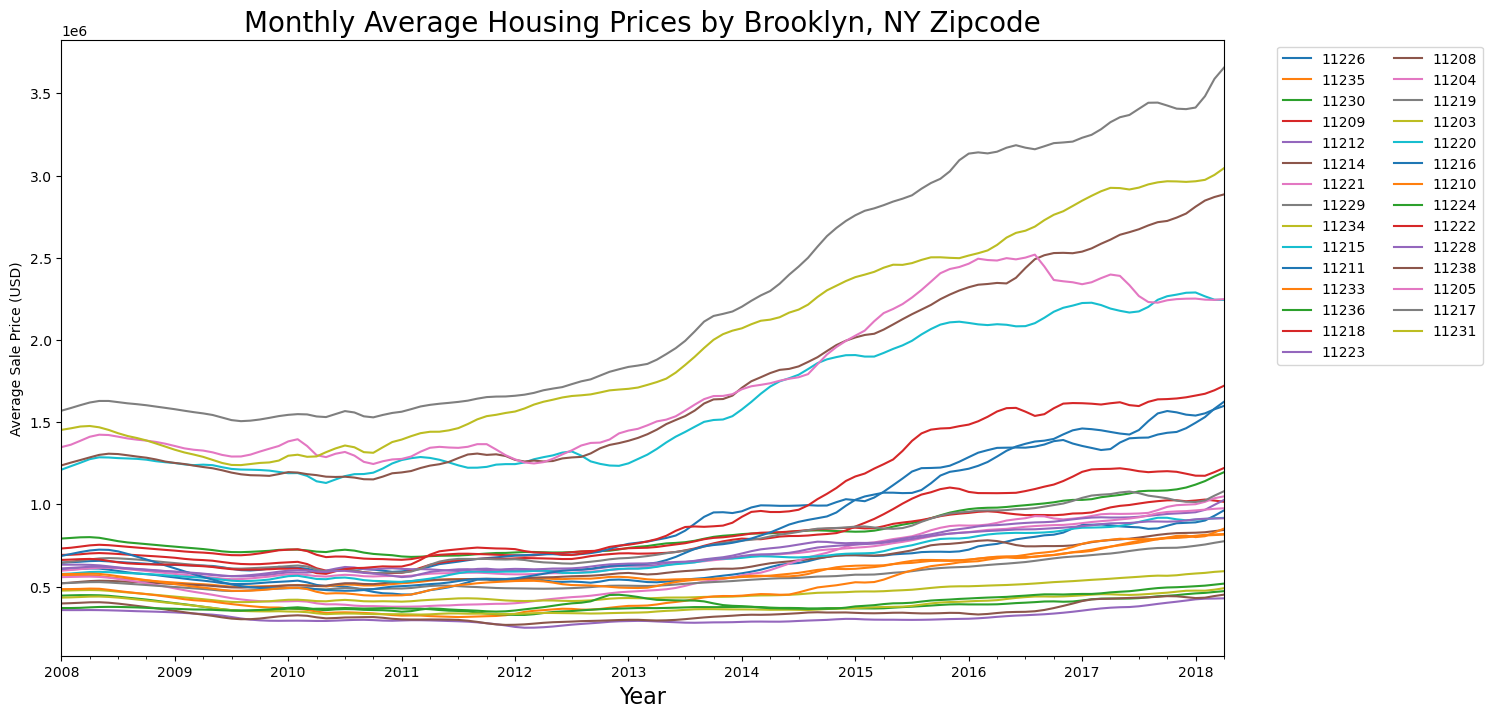

In [36]:
#A deeper look at 2008 above
for zipcode in dfm.RegionName.unique():
    temp_df = dfm[dfm.RegionName == zipcode]
    temp_df['2008':]['MeanValue'].plot(figsize = (15,8), label=zipcode)

plt.legend(bbox_to_anchor=(1.04,1), loc='upper left', ncol=2)
plt.xlabel("Year", fontsize = 16)
plt.ylabel("Average Sale Price (USD)")
plt.title('Monthly Average Housing Prices by Brooklyn, NY Zipcode', fontsize = 20);
plt.show()

To get more accurate prediction on 2020 and onwards data,  we decided to use data 2011-Present. 

### Seasonal Decomposition for 2011 and Above

Second, let's see if there was seasonal effect on house price.

In [37]:
df2011 = dfm['2011':]
month_avg = df2011.groupby('Month')['MeanValue'].mean()

In [38]:
month_avg.head()

Month
2011-01-01    633365.517241
2011-02-01    638334.482759
2011-03-01    647358.620690
2011-04-01    655465.517241
2011-05-01    659955.172414
Name: MeanValue, dtype: float64

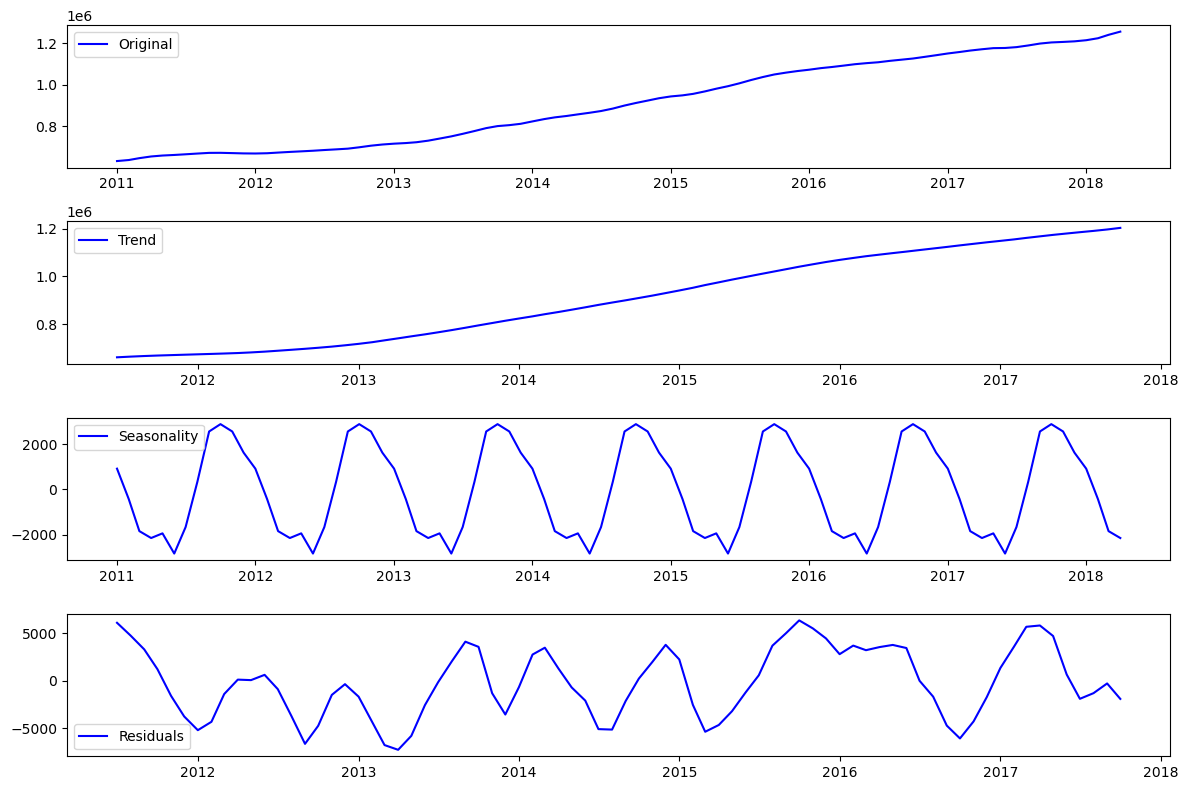

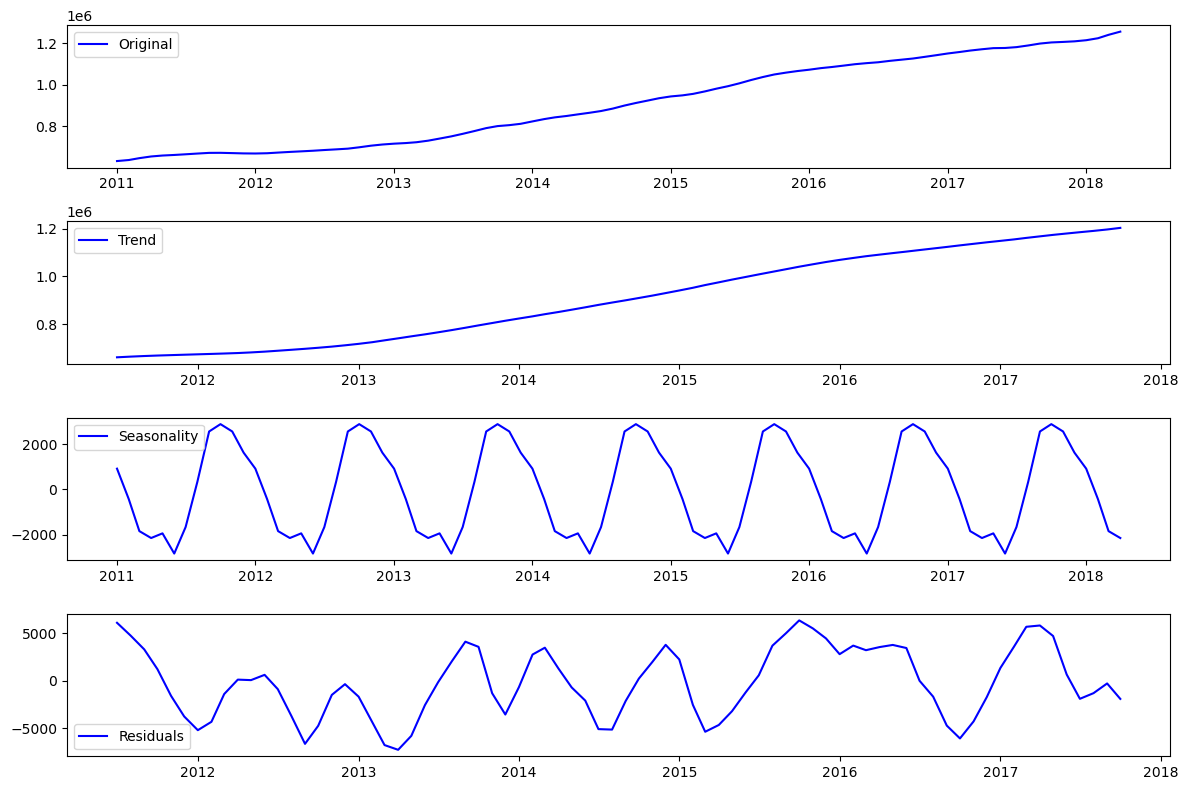

In [40]:
decomposition = sm.tsa.seasonal_decompose(month_avg, model='additive')

#Gather the trend, seasonality, and residuals
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(month_avg, label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='blue')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='blue')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

An upward trend is present with yearly sesasonal changes. Let's check stationarity of residuals.

The Dickey Fuller test is used to test stationarity. The null hypothesis is the existence of autoregression, and the alternative hypothesis is stationarity. 

In [41]:
def stationarity_check(TS):
    
    # Import adfuller
    from statsmodels.tsa.stattools import adfuller
    
    # Calculate rolling statistics
    roll_mean = TS.rolling(window=8, center=False).mean()
    roll_std = TS.rolling(window=8, center=False).std()
    
    # Perform the Dickey Fuller test
    dftest = adfuller(TS) 
    
    # Plot rolling statistics:
    fig = plt.figure(figsize=(12,6))
    orig = plt.plot(TS, color='blue',label='Original')
    mean = plt.plot(roll_mean, color='red', label='Rolling Mean')
    std = plt.plot(roll_std, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Print Dickey-Fuller test results
    print('Results of Dickey-Fuller Test: \n')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 
                                             '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    return None

In [42]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)

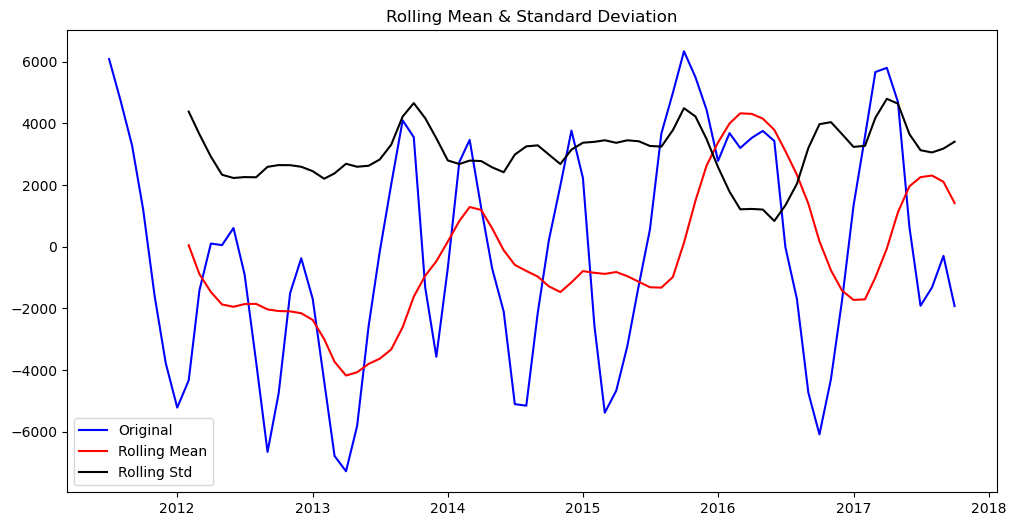

Results of Dickey-Fuller Test: 

Test Statistic                 -2.527008
p-value                         0.109040
#Lags Used                      6.000000
Number of Observations Used    69.000000
Critical Value (1%)            -3.528890
Critical Value (5%)            -2.904440
Critical Value (10%)           -2.589656
dtype: float64


In [43]:
stationarity_check(ts_log_decompose)

The p-value is larger than 0.05. We can accept the null which means the residuals are not stationary. 

### Autocorrelation

In [44]:
month_avg.plot()

<Axes: xlabel='Month'>

#### The monthly average house price of Brooklyn increased year over year. No obvious autocorrelation and partial autocorrelation is present. 

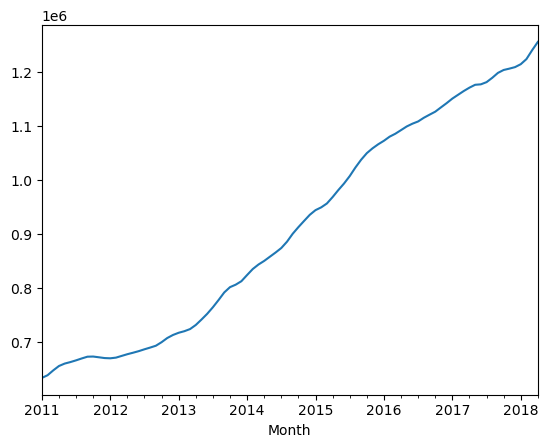

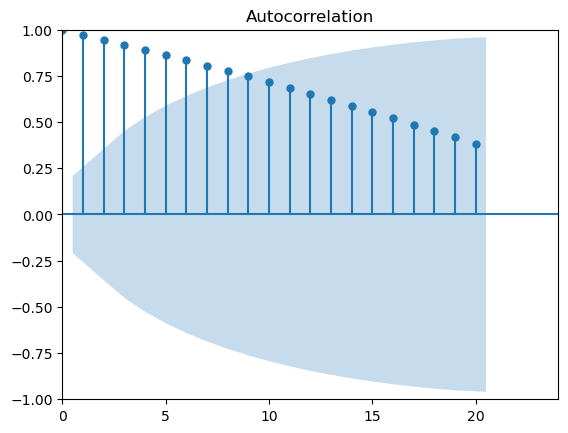

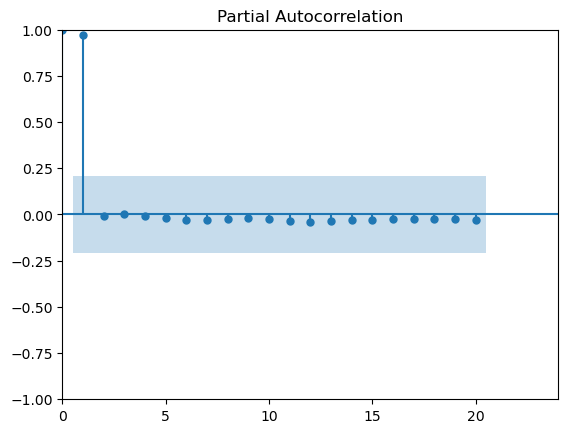

In [45]:
plot_acf(month_avg); plt.xlim(0,24); plt.show()
plot_pacf(month_avg); plt.xlim(0,24); plt.ylim(-1,1);plt.show()

#### If take lag = 3 difference. Autocorrlation appears.

In [46]:
month_avg.diff(periods=3).plot()

<Axes: xlabel='Month'>

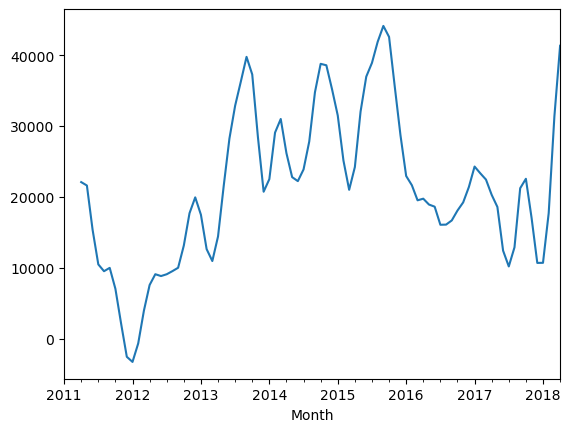

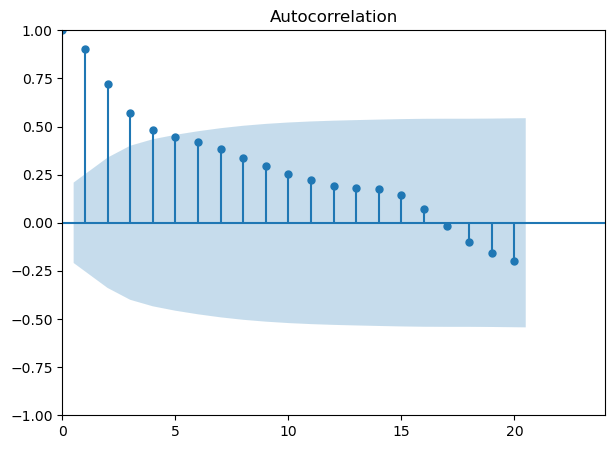

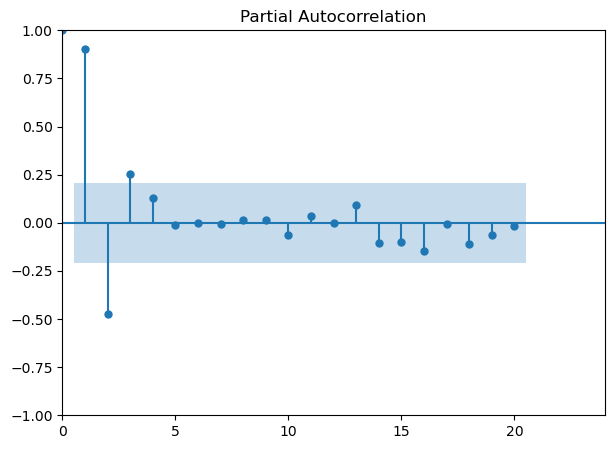

In [47]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from matplotlib.pylab import rcParams

rcParams['figure.figsize']=7,5
plot_acf(month_avg.diff(periods=3).bfill()); plt.xlim(0,24); plt.show()
plot_pacf(month_avg.diff(periods=3).bfill()); plt.xlim(0,24); plt.ylim(-1,1);plt.show()

## Step 4: Initial SARIMA Models on Sample Zip Codes
<a id='005'></a>

Perform SARIMA model on 3 sample zip codes.

In [48]:
dfm.RegionName.unique()

array([11226, 11235, 11230, 11209, 11212, 11214, 11221, 11229, 11234,
       11215, 11211, 11233, 11236, 11218, 11223, 11208, 11204, 11219,
       11203, 11220, 11216, 11210, 11224, 11222, 11228, 11238, 11205,
       11217, 11231])

In [49]:
#Select 3 zipcodes
zip_dfs = []
zip_list = np.array([11231,11205,11217])
for x in zip_list:
    zip_dfs.append(pd.DataFrame(dfm[dfm['RegionName']==x][['MeanValue']].copy()))


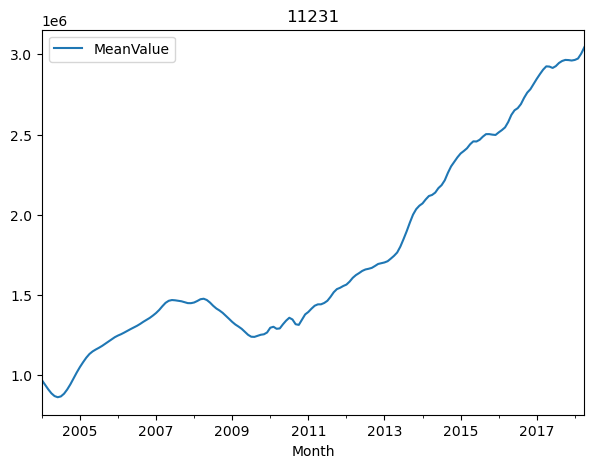

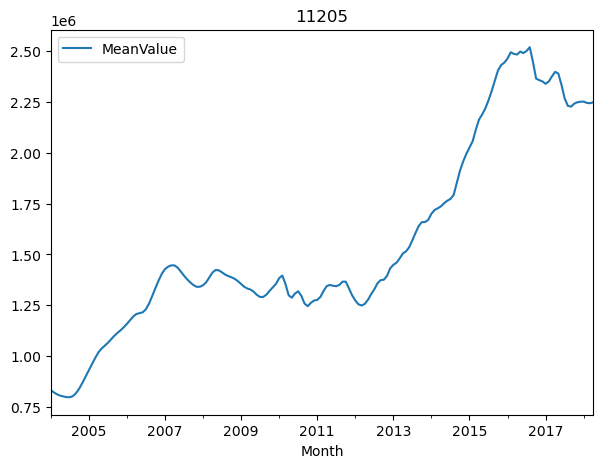

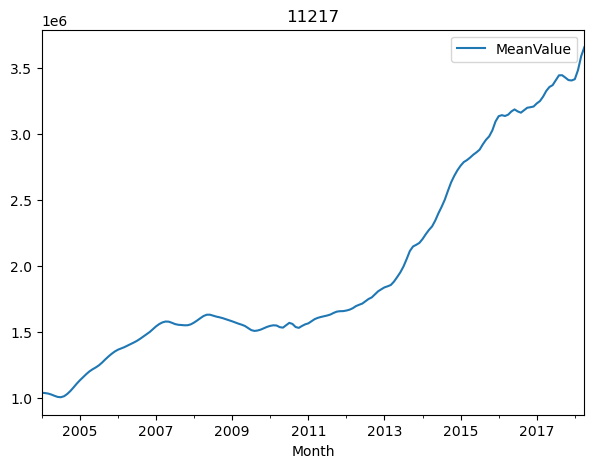

In [50]:
for df, name in zip(zip_dfs, zip_list):
    df.plot()
    plt.title(name)
    plt.show()

In [51]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0,2)
# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p,d,q))
# Generate all different combinations of seasonal p, d and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [52]:
print(pdqs)

[(0, 0, 0, 12), (0, 0, 1, 12), (0, 1, 0, 12), (0, 1, 1, 12), (1, 0, 0, 12), (1, 0, 1, 12), (1, 1, 0, 12), (1, 1, 1, 12)]


In [53]:
#Run SARIMA
ans = []

for df, name in zip(zip_dfs, zip_list):
    for para1 in pdq:
        for para2 in pdqs:
            try:
                mod = sm.tsa.statespace.SARIMAX(df,
                                                order = para1,
                                                seasonal_order = para2,
                                                enforce_stationarity = False,
                                                enforce_invertibility = False)
                output = mod.fit()
                ans.append([name, para1, para2, output.aic])
                print('Result for {}'.format(name) + ' ARIMA {} x {}12 : AIC Calculated = {}'.format(para1, para2, output.aic))
            except:
                continue

C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11231 ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5423.9708093629815
Result for 11231 ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4953.349694304559
Result for 11231 ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 4343.500124754707


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11231 ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 3964.1793652714414
Result for 11231 ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4224.726704777125


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11231 ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4167.708543663068
Result for 11231 ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 3911.0932416918577


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11231 ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 3886.92056694436
Result for 11231 ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 5271.202299206425
Result for 11231 ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4873.687915051443


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11231 ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4438.507909420725


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11231 ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 3870.2653598600596
Result for 11231 ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4921.714485065764


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11231 ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4862.1319773047435
Result for 11231 ARIMA (0, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 3913.1470637304674


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11231 ARIMA (0, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4100.647854319763
Result for 11231 ARIMA (0, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 3861.602234144147
Result for 11231 ARIMA (0, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 3561.8269325149604
Result for 11231 ARIMA (0, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 3598.6345347651754
Result for 11231 ARIMA (0, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 3298.5573775418047


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11231 ARIMA (0, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 3571.7301436694715
Result for 11231 ARIMA (0, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 3545.7872474569367
Result for 11231 ARIMA (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 3305.4054377810953


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11231 ARIMA (0, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 3286.5434875354804
Result for 11231 ARIMA (0, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 3691.408441618298
Result for 11231 ARIMA (0, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 3419.4010815046477
Result for 11231 ARIMA (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 3565.5281510856103


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11231 ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 3177.368616245625
Result for 11231 ARIMA (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 3469.9512896516508
Result for 11231 ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 3421.400120323622


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11231 ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 3242.694999576198


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11231 ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 3199.745929799867
Result for 11231 ARIMA (1, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 3799.3984448890315
Result for 11231 ARIMA (1, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 12287.282260137248
Result for 11231 ARIMA (1, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 3629.473108489582


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11231 ARIMA (1, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 3353.9474246306227
Result for 11231 ARIMA (1, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 3515.9890600201375
Result for 11231 ARIMA (1, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 11529.24082087075
Result for 11231 ARIMA (1, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 3315.1127909914476


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11231 ARIMA (1, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 3317.0829204398237
Result for 11231 ARIMA (1, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 3622.630047755568


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11231 ARIMA (1, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 5866.7267422219975
Result for 11231 ARIMA (1, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 3660.8101526050173


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.w

Result for 11231 ARIMA (1, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4937.220945024952
Result for 11231 ARIMA (1, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 3381.655873005033


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 

Result for 11231 ARIMA (1, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 5728.796260257532
Result for 11231 ARIMA (1, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 3257.3771665145296


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 

Result for 11231 ARIMA (1, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4940.156976685779
Result for 11231 ARIMA (1, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 3590.580930965584
Result for 11231 ARIMA (1, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 3341.3549552780705
Result for 11231 ARIMA (1, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 3456.78803464577


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11231 ARIMA (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 3182.3947343989676
Result for 11231 ARIMA (1, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 3340.4593052338714
Result for 11231 ARIMA (1, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 3342.4530701185686


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11231 ARIMA (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 3152.2700026004172
Result for 11231 ARIMA (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 3154.1497149255465


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11231 ARIMA (1, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 3558.3971696526182
Result for 11231 ARIMA (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 3278.7614824311786
Result for 11231 ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 3427.8463127446316
Result for 11231 ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 3134.173215835504
Result for 11231 ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 3299.4145561362084


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11231 ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 3279.6679674509587
Result for 11231 ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 3142.859577473212


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11231 ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 3114.3225284358305
Result for 11205 ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5379.953671313097
Result for 11205 ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4910.00232710122
Result for 11205 ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 4347.903583088452


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11205 ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 3987.343239500786
Result for 11205 ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4340.589134433099


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11205 ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4288.2768077604305
Result for 11205 ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 3994.708754284097


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11205 ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 3969.677025710955
Result for 11205 ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 5227.254918760085


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11205 ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 5160.454080677077
Result for 11205 ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4434.767609614235


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11205 ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 3975.456345489309
Result for 11205 ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 5291.417259737498


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11205 ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 5158.25719787168
Result for 11205 ARIMA (0, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 3925.714920151912


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11205 ARIMA (0, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 3975.8418381863166
Result for 11205 ARIMA (0, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 3923.176889074811
Result for 11205 ARIMA (0, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 3651.078233254305
Result for 11205 ARIMA (0, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 3737.8241919908405


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11205 ARIMA (0, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 3436.7169588203014
Result for 11205 ARIMA (0, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 3674.531159717189
Result for 11205 ARIMA (0, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 3652.6633203100937
Result for 11205 ARIMA (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 3453.1445175012186


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11205 ARIMA (0, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 3429.9872650883412
Result for 11205 ARIMA (0, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 3739.7273971523846
Result for 11205 ARIMA (0, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 3478.486899642053


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11205 ARIMA (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 3651.6560373661496
Result for 11205 ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 3328.6556374970132


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11205 ARIMA (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 3521.9618008346984
Result for 11205 ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 3479.568836425228


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11205 ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 3377.4131412999714


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11205 ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 3330.584056201548
Result for 11205 ARIMA (1, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 3930.0629066955735
Result for 11205 ARIMA (1, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 7230.066270149637
Result for 11205 ARIMA (1, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 3762.733474314592


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11205 ARIMA (1, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 3534.47055742015
Result for 11205 ARIMA (1, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 3662.790930947048
Result for 11205 ARIMA (1, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 6730.908640236867
Result for 11205 ARIMA (1, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 3456.6741236967064


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11205 ARIMA (1, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 3457.7007449291523
Result for 11205 ARIMA (1, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 3753.7492258894404


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11205 ARIMA (1, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 6893.109164782298
Result for 11205 ARIMA (1, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 3691.6862929049703


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.w

Result for 11205 ARIMA (1, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 5057.949845856225
Result for 11205 ARIMA (1, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 3515.1894627817137


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11205 ARIMA (1, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 6509.732431059063
Result for 11205 ARIMA (1, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 3371.044378632756


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.w

Result for 11205 ARIMA (1, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4687.006430493042
Result for 11205 ARIMA (1, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 3767.299499684117
Result for 11205 ARIMA (1, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 3501.8854657948664
Result for 11205 ARIMA (1, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 3643.91905478042


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11205 ARIMA (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 3347.4989981611616
Result for 11205 ARIMA (1, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 3502.2621481257056
Result for 11205 ARIMA (1, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 3503.8677836841134


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11205 ARIMA (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 3324.1196088102006
Result for 11205 ARIMA (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 3325.01843632598


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11205 ARIMA (1, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 3722.847528438274
Result for 11205 ARIMA (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 3428.3833868125694
Result for 11205 ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 3604.637172857384


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11205 ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 3287.5722778802337
Result for 11205 ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 3450.8221875264117


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11205 ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 3425.3164565489033
Result for 11205 ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 3310.2287215169727


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11205 ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 3275.26795932032
Result for 11217 ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5468.611984809286
Result for 11217 ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 13101848.938531034
Result for 11217 ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 4393.223069560115


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11217 ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4015.234860505023
Result for 11217 ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4259.022133249397


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11217 ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4204.784414698346
Result for 11217 ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 3886.6568383415506


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11217 ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 3859.3667087670274
Result for 11217 ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 5315.382505913818


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11217 ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 13364997.594887659
Result for 11217 ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4495.701191604133


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11217 ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 3916.285208610272
Result for 11217 ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 5390.62575737511


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11217 ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 5253.571483915684
Result for 11217 ARIMA (0, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4076.952304017049


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11217 ARIMA (0, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 3902.4430711833947
Result for 11217 ARIMA (0, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 3929.103554355881
Result for 11217 ARIMA (0, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 3608.6946219501965
Result for 11217 ARIMA (0, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 3590.5887765076595
Result for 11217 ARIMA (0, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 3322.845347796177


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11217 ARIMA (0, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 3599.3398214689837
Result for 11217 ARIMA (0, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 3578.616905378565
Result for 11217 ARIMA (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 3344.2857254936257


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11217 ARIMA (0, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 3324.435828365934
Result for 11217 ARIMA (0, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 3738.527043856913
Result for 11217 ARIMA (0, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 3456.3159111593122
Result for 11217 ARIMA (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 3549.7058250369128


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11217 ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 3188.8111380824207
Result for 11217 ARIMA (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 3521.658401526178


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11217 ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 3458.0683099262874
Result for 11217 ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 3231.899396935677


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11217 ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 3190.5787695631075
Result for 11217 ARIMA (1, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 3848.1695680533976
Result for 11217 ARIMA (1, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 3561.6836219526863


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11217 ARIMA (1, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 3615.2932529477025


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 

Result for 11217 ARIMA (1, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 3383.9077337491553
Result for 11217 ARIMA (1, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 3569.947889965981
Result for 11217 ARIMA (1, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 3563.531272130266
Result for 11217 ARIMA (1, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 3346.29360830353


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11217 ARIMA (1, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 3348.766044704057
Result for 11217 ARIMA (1, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 3696.510873211653


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 

Result for 11217 ARIMA (1, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 6472.07486334251
Result for 11217 ARIMA (1, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 3657.0984029687884


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11217 ARIMA (1, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4960.555231325657


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11217 ARIMA (1, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 3429.8851131682104


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 

Result for 11217 ARIMA (1, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 3402.7324576539822
Result for 11217 ARIMA (1, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 3230.8621770044892


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11217 ARIMA (1, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4466.10797084105
Result for 11217 ARIMA (1, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 3665.5380395560987
Result for 11217 ARIMA (1, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 3417.241285266538
Result for 11217 ARIMA (1, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 3489.974396641738


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11217 ARIMA (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 3226.2993768568977
Result for 11217 ARIMA (1, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 3417.14540603299
Result for 11217 ARIMA (1, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 3419.0962413746156


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11217 ARIMA (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 3215.9770411918053
Result for 11217 ARIMA (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 3217.697991550837
Result for 11217 ARIMA (1, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 3633.351937226497


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11217 ARIMA (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 3339.38106197513
Result for 11217 ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 3467.876691832281


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11217 ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 3161.8845620785523
Result for 11217 ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 3359.6502237364507


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11217 ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 3339.8988471416014
Result for 11217 ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 3183.499383179962


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11217 ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 3163.8163476690625


In [54]:
result = pd.DataFrame(ans, columns = ['name','pdq','pdqs','AIC'])

The **Akaike Information Critera (AIC)** is a widely used measure of a statistical model. It basically quantifies 1) the goodness of fit, and 2) the simplicity/parsimony, of the model into a single statistic.

When comparing two models, the one with the lower AIC is generally “better”. 

In [55]:
#Return the best set of parameters based on AIC
best_para = result.loc[result.groupby("name")["AIC"].idxmin()]

In [56]:
best_para

,name,pdq,pdqs,AIC
127,11205,"(1, 1, 1)","(1, 1, 1, 12)",3275.267959
187,11217,"(1, 1, 1)","(0, 1, 1, 12)",3161.884562
63,11231,"(1, 1, 1)","(1, 1, 1, 12)",3114.322528


In [57]:
#Mean house price in Brooklyn is above $1 Million
dfm['2017':]['MeanValue'].mean()

np.float64(1195787.9310344828)

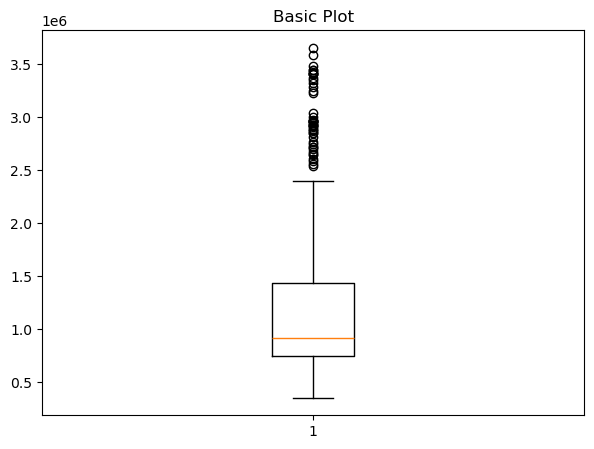

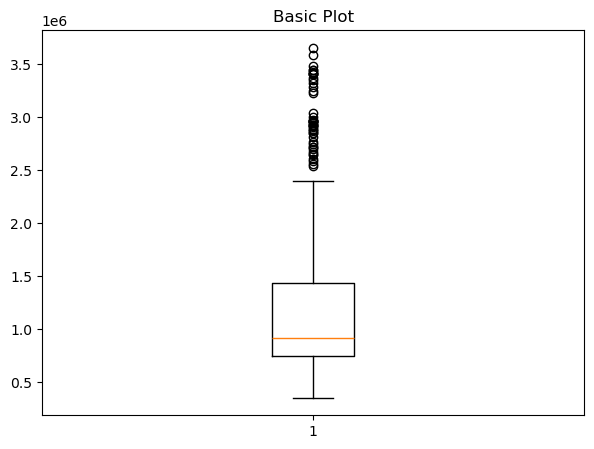

In [59]:
fig1, ax1 = plt.subplots()
ax1.set_title('Basic Plot')
ax1.boxplot(dfm['2017':]['MeanValue'])
plt.show()

### Plug the optimal parameter values into a new SARIMAX model to have a deeper look

In [60]:
# plug the optimal parameter values into a new SARIMAX model.

for name, pdq, pdqs, df in zip(best_para['name'], best_para['pdq'], best_para['pdqs'], zip_dfs):
    
    ARIMA_MODEL = sm.tsa.SARIMAX(df, 
                           order = pdq,
                           seasonal_order = pdqs,
                           enforce_stationarity = False,
                           enforce_invertibility = False)
    
    output = ARIMA_MODEL.fit()
    print('SARIMA Model Result for {}'.format(name))
    print(output.summary().tables[1])
                           
                           
# Fit the model and print results

C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMA Model Result for 11205
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7302      0.071     10.278      0.000       0.591       0.869
ma.L1          0.2318      0.033      7.053      0.000       0.167       0.296
ar.S.L12      -0.5738      0.086     -6.685      0.000      -0.742      -0.406
ma.S.L12      -0.0071      0.054     -0.131      0.895      -0.113       0.099
sigma2      1.344e+08   9.15e-11   1.47e+18      0.000    1.34e+08    1.34e+08
SARIMA Model Result for 11217


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4732      0.087      5.435      0.000       0.303       0.644
ma.L1          0.6258      0.064      9.720      0.000       0.500       0.752
ma.S.L12      -0.1747      0.043     -4.091      0.000      -0.258      -0.091
sigma2      4.017e+08    1.6e-11   2.52e+19      0.000    4.02e+08    4.02e+08


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMA Model Result for 11231
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4580      0.064      7.165      0.000       0.333       0.583
ma.L1          0.6972      0.047     14.867      0.000       0.605       0.789
ar.S.L12       0.0497      2.356      0.021      0.983      -4.568       4.668
ma.S.L12      -0.0633      2.350     -0.027      0.978      -4.669       4.542
sigma2        1.4e+08    9.9e-08   1.41e+15      0.000     1.4e+08     1.4e+08


### Make dynamic forecast using data up to 2017-06-01 and compare with real values post 2017-06-01

C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


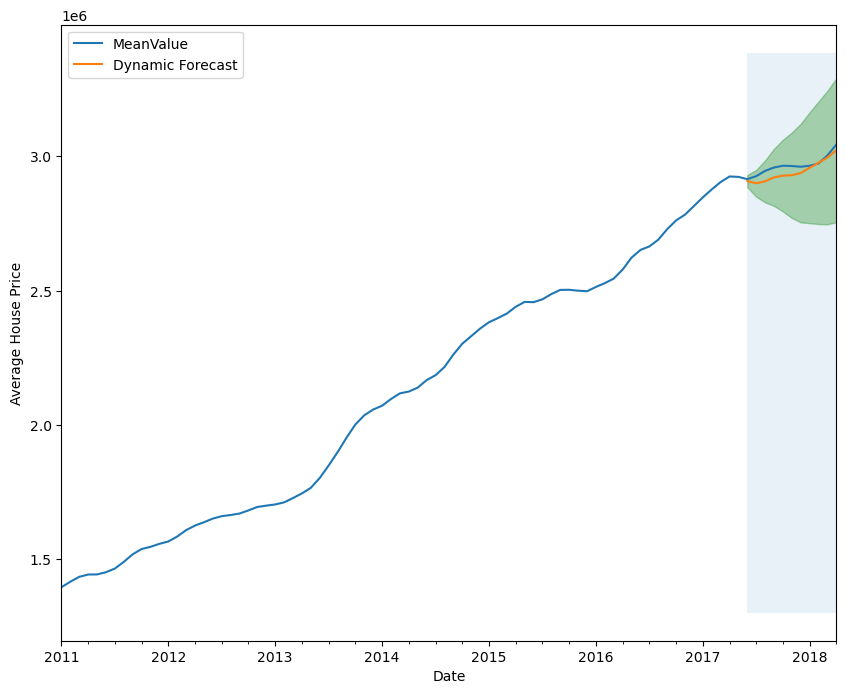

The Mean Squared Error of our forecasts is 25756.56


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


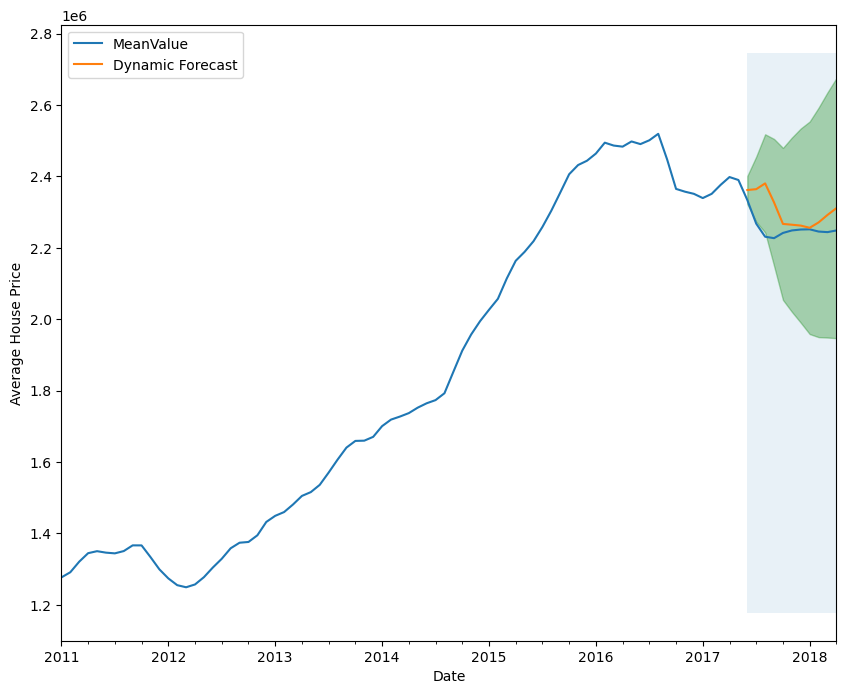

The Mean Squared Error of our forecasts is 67677.54


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


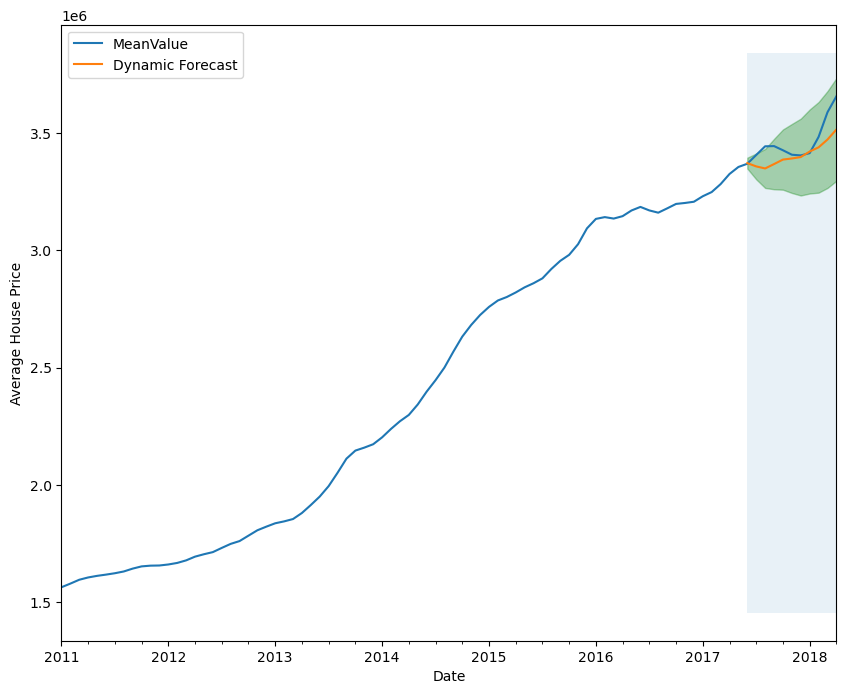

The Mean Squared Error of our forecasts is 70471.24


In [61]:
#Make Prediction post 2016 and compare with real values
summary_table = pd.DataFrame()
Zipcode = []
MSE_Value = []
models = []
for name, pdq, pdqs, df in zip(best_para['name'], best_para['pdq'], best_para['pdqs'], zip_dfs):

    ARIMA_MODEL = sm.tsa.SARIMAX(df,
                                 order = pdq,
                                 seasonal_order = pdqs,
                                 enforce_stationarity = False,
                                 enforce_invertibility = False)
                                
    output = ARIMA_MODEL.fit()
    models.append(output)
    
    #get dynamic predictions starting 2017-06-01
    pred_dynamic = output.get_prediction(start=pd.to_datetime('2017-06-01'), dynamic = True, full_results = True)
    pred_dynamic_conf = pred_dynamic.conf_int()
    zip_forecasted = pred_dynamic.predicted_mean
    zip_truth = df['2017-06-01':]['MeanValue']
    
    #Plot the dynamic forecast with confidence intervals as above
    ax = df['2011':].plot(label='observed', figsize=(10, 8))
    pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

    ax.fill_between(pred_dynamic_conf.index,
                    pred_dynamic_conf.iloc[:, 0],
                    pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

    ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2017-06-01'), zip_forecasted.index[-1], alpha=.1, zorder=-1)

    ax.set_xlabel('Date')
    ax.set_ylabel('Average House Price')

    plt.legend()
    plt.show()

    #print(type(zip_forecasted))
    #print(zip_truth)
    sqrt_mse = np.sqrt(((zip_forecasted - zip_truth)**2).mean())
    print('The Mean Squared Error of our forecasts is {}'.format(round(sqrt_mse, 2))) 
    
    Zipcode.append(name)
    MSE_Value.append(sqrt_mse)
    
summary_table['Zipcode'] = Zipcode
summary_table['Sqrt_MSE'] = MSE_Value
      

In [62]:
summary_table

,Zipcode,Sqrt_MSE
0,11205,25756.564426
1,11217,67677.540732
2,11231,70471.236968


### Producing and Visualizing Forecasts

In [65]:
forecast_table = pd.DataFrame()
current = []
forecast_3Yr = []
forecast_5Yr =[]
for zipcode, output, df in zip(Zipcode, models, zip_dfs):
    pred_3 = output.get_forecast(steps = 36)
    pred_conf_3 = pred_3.conf_int()
    forecast_3 = pred_3.predicted_mean.to_numpy()[-1]
    pred_5 = output.get_forecast(steps = 60)
    pred_conf_5 = pred_5.conf_int()
    forecast_5 = pred_5.predicted_mean.to_numpy()[-1]
    #current.append(df['2018-04']['MeanValue'][0])
    current.append(df.loc['2018-04-01', 'MeanValue'])
    forecast_3Yr.append(forecast_3)
    forecast_5Yr.append(forecast_5)

forecast_table['Zipcode'] = Zipcode
forecast_table['Current Value'] = current
forecast_table['3 Years Value'] = forecast_3Yr
forecast_table['5 Years Value'] = forecast_5Yr
forecast_table['3Yr-ROI']=(forecast_table['3 Years Value'] - forecast_table['Current Value'])/forecast_table['Current Value']
forecast_table['5Yr-ROI']=(forecast_table['5 Years Value'] - forecast_table['Current Value'])/forecast_table['Current Value']

In [66]:
forecast_table

,Zipcode,Current Value,3 Years Value,5 Years Value,3Yr-ROI,5Yr-ROI
0,11205,3044500.0,3.764785e+06,4.209853e+06,0.236586,0.382773
1,11217,2248400.0,1.826419e+06,1.547083e+06,-0.187680,-0.311918
2,11231,3656000.0,4.669342e+06,5.344744e+06,0.277172,0.461910


## Step 5: SARIMA models on all Zipcodes 
<a id='006'></a>

Iterate through all zipcodes.

In [67]:
zip_dfs = []
zip_list = dfm.RegionName.unique()
for x in zip_list:
    zip_dfs.append(pd.DataFrame(dfm[dfm['RegionName']==x][['MeanValue']].copy()))
    

In [68]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0,2)
# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p,d,q))
# Generate all different combinations of seasonal p, d and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [69]:
#Run SARIMA
start=time.time()
ans = []

for df, name in zip(zip_dfs, zip_list):
    for para1 in pdq:
        for para2 in pdqs:
            try:
                mod = sm.tsa.statespace.SARIMAX(df,
                                                order = para1,
                                                seasonal_order = para2,
                                                enforce_stationarity = False,
                                                enforce_invertibility = False)
                output = mod.fit()
                ans.append([name, para1, para2, output.aic])
                print('Result for {}'.format(name) + ' ARIMA {} x {}12 : AIC Calculated = {}'.format(para1, para2, output.aic))
            except:
                continue
                


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11226 ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 7686.987458773749
Result for 11226 ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 341013.49549970386
Result for 11226 ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 6252.839047360809
Result for 11226 ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 5938.651692048987
Result for 11226 ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 6176.700787594302


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11226 ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 6151.121734548341
Result for 11226 ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 5927.154967620481


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11226 ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 5965.399947029934
Result for 11226 ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 7467.09129659485


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11226 ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 315931.8501166887
Result for 11226 ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 6053.0584734647


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11226 ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 5847.601640846289
Result for 11226 ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 7121.1511131755915


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11226 ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 7066.839631472078
Result for 11226 ARIMA (0, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 5790.891574756908


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11226 ARIMA (0, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 5742.629704019895
Result for 11226 ARIMA (0, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5415.9435402145455
Result for 11226 ARIMA (0, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 5182.227960040929
Result for 11226 ARIMA (0, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 5304.039975285405


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11226 ARIMA (0, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4992.363689801634
Result for 11226 ARIMA (0, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 5199.921309178136
Result for 11226 ARIMA (0, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 5180.227515799277
Result for 11226 ARIMA (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4973.72850676796


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11226 ARIMA (0, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4950.843782204056
Result for 11226 ARIMA (0, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 5184.637204701278
Result for 11226 ARIMA (0, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4957.7468340781315


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11226 ARIMA (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 5182.218778045881
Result for 11226 ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4858.70273079415


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11226 ARIMA (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4995.90986303076
Result for 11226 ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4959.745834069238


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11226 ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4911.442496549792


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11226 ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4860.068130444754
Result for 11226 ARIMA (1, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5372.04284968167


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11226 ARIMA (1, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 5196.38153426644
Result for 11226 ARIMA (1, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 5325.1548224863855


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.w

Result for 11226 ARIMA (1, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 5087.628996116855
Result for 11226 ARIMA (1, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 5134.841411085971
Result for 11226 ARIMA (1, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 5273.641129488782
Result for 11226 ARIMA (1, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4992.97319075266


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11226 ARIMA (1, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4992.855871800397
Result for 11226 ARIMA (1, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 5180.937182999871


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11226 ARIMA (1, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 5078.940009036226
Result for 11226 ARIMA (1, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 5279.7758352197025


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.w

Result for 11226 ARIMA (1, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 6639.494875240502
Result for 11226 ARIMA (1, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4945.618994009423


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11226 ARIMA (1, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 5080.897966085631
Result for 11226 ARIMA (1, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4927.830677149596


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11226 ARIMA (1, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 5553.651079516547
Result for 11226 ARIMA (1, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5106.92665644492
Result for 11226 ARIMA (1, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4857.301460720702
Result for 11226 ARIMA (1, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 5088.932413088176


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11226 ARIMA (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4798.5751321874395
Result for 11226 ARIMA (1, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4864.184731936434
Result for 11226 ARIMA (1, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4859.3014537419085


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11226 ARIMA (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4780.862788072864
Result for 11226 ARIMA (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4778.1698610872645
Result for 11226 ARIMA (1, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 5051.547212070067


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11226 ARIMA (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4806.023666932804
Result for 11226 ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 5029.988469099513


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11226 ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4731.85203925059
Result for 11226 ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4835.757628907137
Result for 11226 ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4805.174002191021


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11226 ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4750.428367253617


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11226 ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4714.876675353307
Result for 11235 ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 7686.239800391144
Result for 11235 ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 7183.064166232194
Result for 11235 ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 6136.231288436835


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11235 ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 5856.820108325686
Result for 11235 ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 6064.1718082123225
Result for 11235 ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 6005.414509175573


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11235 ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 5683.047919360209


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11235 ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 7508.943133517765
Result for 11235 ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 7466.392359757914


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11235 ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 7083.123977186838
Result for 11235 ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 6170.701813238066


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.w

Result for 11235 ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 8507.62192022639
Result for 11235 ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 7614.840298038389
Result for 11235 ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 7065.694322257667


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11235 ARIMA (0, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 5660.362241503077


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11235 ARIMA (0, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 7389.724507962718
Result for 11235 ARIMA (0, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5168.230761657868
Result for 11235 ARIMA (0, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4886.1963883050585
Result for 11235 ARIMA (0, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 4905.544348790674


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11235 ARIMA (0, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4669.988099521521
Result for 11235 ARIMA (0, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4874.594879322694
Result for 11235 ARIMA (0, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4859.034716395941
Result for 11235 ARIMA (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4689.212495569065


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11235 ARIMA (0, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4669.949243252513
Result for 11235 ARIMA (0, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 4919.050335531282


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11235 ARIMA (0, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4598.019093500232
Result for 11235 ARIMA (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4749.5185071414235


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11235 ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4465.03410501873
Result for 11235 ARIMA (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4679.265853003859


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11235 ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4680.77625545012
Result for 11235 ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4503.540506987298


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11235 ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4443.891365558687
Result for 11235 ARIMA (1, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5102.746835235477
Result for 11235 ARIMA (1, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4844.661282562215


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11235 ARIMA (1, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 4926.061509516208


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 

Result for 11235 ARIMA (1, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4706.343288799057
Result for 11235 ARIMA (1, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4844.6405860900895
Result for 11235 ARIMA (1, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4903.744716023173
Result for 11235 ARIMA (1, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4690.997395352188


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.w

Result for 11235 ARIMA (1, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4695.80173776321
Result for 11235 ARIMA (1, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 4854.612479960004
Result for 11235 ARIMA (1, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4627.6186865381205
Result for 11235 ARIMA (1, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4973.337105131083


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.w

Result for 11235 ARIMA (1, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4484.970747108599
Result for 11235 ARIMA (1, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4659.167315648516


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 

Result for 11235 ARIMA (1, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4629.612192253286
Result for 11235 ARIMA (1, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4517.164476279011


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11235 ARIMA (1, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4977.2226282762
Result for 11235 ARIMA (1, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 4710.301961830058
Result for 11235 ARIMA (1, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4509.493898221817
Result for 11235 ARIMA (1, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 4662.668869738202


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 

Result for 11235 ARIMA (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4418.262401413722
Result for 11235 ARIMA (1, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4509.494010852848
Result for 11235 ARIMA (1, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4511.480578259204


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11235 ARIMA (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4398.392217289826


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11235 ARIMA (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4394.71532980552
Result for 11235 ARIMA (1, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 4655.050551159975
Result for 11235 ARIMA (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4406.399327484073
Result for 11235 ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4618.5685271227485


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11235 ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4321.554771249749
Result for 11235 ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4422.9858868335405
Result for 11235 ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4408.362853338624


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11235 ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4354.143770409875


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11235 ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4312.238199836023
Result for 11230 ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 7851.378265304077
Result for 11230 ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 680024.5567496539
Result for 11230 ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 6296.970752436353


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11230 ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 6010.224771664962
Result for 11230 ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 6208.386084453923


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11230 ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 6163.250695350802
Result for 11230 ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 5864.522375545278


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11230 ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 7803.542446094708
Result for 11230 ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 7630.789438200217


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 

Result for 11230 ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 655499.0980653721
Result for 11230 ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 6351.887072729771
Result for 11230 ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 5789.234138730797
Result for 11230 ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 7800.696798878653


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11230 ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 7651.7050556736
Result for 11230 ARIMA (0, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 5940.858582053376


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11230 ARIMA (0, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 6175.918566282718
Result for 11230 ARIMA (0, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5393.31571439869
Result for 11230 ARIMA (0, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 5138.517204481753
Result for 11230 ARIMA (0, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 5164.60559822987
Result for 11230 ARIMA (0, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4890.857927624113


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11230 ARIMA (0, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 5128.937937700679
Result for 11230 ARIMA (0, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 5105.653725525007
Result for 11230 ARIMA (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4882.518633750405
Result for 11230 ARIMA (0, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4865.712186381558


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11230 ARIMA (0, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 5158.926990446314
Result for 11230 ARIMA (0, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4919.395757162459
Result for 11230 ARIMA (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 5094.547331828018


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11230 ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4688.822627409634
Result for 11230 ARIMA (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4966.672974031809
Result for 11230 ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4921.0227262266035


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11230 ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4776.905245076517


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11230 ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4690.393638758345
Result for 11230 ARIMA (1, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5319.862512474645
Result for 11230 ARIMA (1, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 5084.685597081485


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11230 ARIMA (1, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 5185.460199592956


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 

Result for 11230 ARIMA (1, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4953.279500252422
Result for 11230 ARIMA (1, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 5080.768658195368
Result for 11230 ARIMA (1, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 5188.37538393297
Result for 11230 ARIMA (1, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4889.254355484997


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11230 ARIMA (1, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 6450.71547413785
Result for 11230 ARIMA (1, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 5079.808737837451


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11230 ARIMA (1, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4853.329586748532
Result for 11230 ARIMA (1, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 5201.945833156262


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.w

Result for 11230 ARIMA (1, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 5224.892436690985
Result for 11230 ARIMA (1, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4875.627413950729


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11230 ARIMA (1, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4855.323683972923
Result for 11230 ARIMA (1, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4774.657959929724


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11230 ARIMA (1, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 5535.64259982839
Result for 11230 ARIMA (1, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 4875.727128328113
Result for 11230 ARIMA (1, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4660.936837361615
Result for 11230 ARIMA (1, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 4840.338112526894


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11230 ARIMA (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4584.6228236883135
Result for 11230 ARIMA (1, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4662.2905651014225
Result for 11230 ARIMA (1, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4662.853753888388


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11230 ARIMA (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4555.674566475116
Result for 11230 ARIMA (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4562.597533237726
Result for 11230 ARIMA (1, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 4822.20417291884


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11230 ARIMA (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4590.062083160441
Result for 11230 ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4786.076405342243


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11230 ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4492.6586145305255
Result for 11230 ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4607.940937126686


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11230 ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4591.88673264192


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11230 ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4527.1858827480855


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11230 ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4485.037253656667
Result for 11209 ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 7836.416695287651
Result for 11209 ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 7326.841492995723
Result for 11209 ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 6231.044773562101


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11209 ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 5947.055203073913
Result for 11209 ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 6152.510623937484


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11209 ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 6108.248429777015
Result for 11209 ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 5815.852252312929


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11209 ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 7742.052590806183
Result for 11209 ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 7615.951212693901


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11209 ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 7646.790065767943
Result for 11209 ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 6282.381683940512


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11209 ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 5723.098254496348
Result for 11209 ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 7263.854820456025


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11209 ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 7640.765936772454
Result for 11209 ARIMA (0, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 5873.885130506476


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11209 ARIMA (0, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 5708.621328701371
Result for 11209 ARIMA (0, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5321.111626779793
Result for 11209 ARIMA (0, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 5078.885855817809
Result for 11209 ARIMA (0, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 5171.3329574941545
Result for 11209 ARIMA (0, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4892.547911372752
Result for 11209 ARIMA (0, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 5088.784183604484


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11209 ARIMA (0, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 5070.242467864118
Result for 11209 ARIMA (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4897.340004554302
Result for 11209 ARIMA (0, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4876.64938555395
Result for 11209 ARIMA (0, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 5071.692831530268


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11209 ARIMA (0, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4844.024932141257
Result for 11209 ARIMA (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 5091.065920757703


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11209 ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4696.999128708927
Result for 11209 ARIMA (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4885.293256500663
Result for 11209 ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4845.982182389202


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11209 ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4778.994183564391


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11209 ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4724.289254148107
Result for 11209 ARIMA (1, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5281.239736892189
Result for 11209 ARIMA (1, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 5052.971373795288


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11209 ARIMA (1, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 5191.680989371727


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11209 ARIMA (1, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4959.193239674991
Result for 11209 ARIMA (1, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 5052.673568299888


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11209 ARIMA (1, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 5146.491935461467
Result for 11209 ARIMA (1, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4903.4960672978605


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11209 ARIMA (1, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 6517.113091260024
Result for 11209 ARIMA (1, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 5036.848736985585


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11209 ARIMA (1, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4945.813310874341
Result for 11209 ARIMA (1, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 5221.71146837484


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.w

Result for 11209 ARIMA (1, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 6347.572323804861
Result for 11209 ARIMA (1, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4835.247470777709


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 

Result for 11209 ARIMA (1, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4946.7515581574735
Result for 11209 ARIMA (1, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4759.0973967348455


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11209 ARIMA (1, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 6078.495515536661
Result for 11209 ARIMA (1, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 4947.538720813114
Result for 11209 ARIMA (1, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4719.059635688368
Result for 11209 ARIMA (1, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 4938.43659791587


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11209 ARIMA (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4672.2428251639285
Result for 11209 ARIMA (1, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4719.686614269447
Result for 11209 ARIMA (1, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4720.750026315637


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11209 ARIMA (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4644.8087033861575
Result for 11209 ARIMA (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4645.178212710778
Result for 11209 ARIMA (1, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 4898.059572341959


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11209 ARIMA (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4637.04450269753
Result for 11209 ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4890.950081589063


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11209 ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4598.775154907251
Result for 11209 ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4666.876216935385
Result for 11209 ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4636.346465892224


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11209 ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4626.84969370438


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11209 ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4585.7357863621255
Result for 11212 ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 7351.430753867524
Result for 11212 ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 6869.044524370878
Result for 11212 ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 5924.190764478067


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11212 ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 5655.318532155819
Result for 11212 ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 5908.706157956624
Result for 11212 ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 5872.8777664865065


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11212 ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 5604.170574064742


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11212 ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 7079.7393955476755
Result for 11212 ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 7133.138819791611


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11212 ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 7211.185370179657
Result for 11212 ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 5923.987843749077


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11212 ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 8156.523781803609
Result for 11212 ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 7235.029181887114


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11212 ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 7103.557900379861
Result for 11212 ARIMA (0, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 5478.502438892794


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11212 ARIMA (0, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 6983.520636518565
Result for 11212 ARIMA (0, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 4985.473140807543
Result for 11212 ARIMA (0, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4761.634881182155
Result for 11212 ARIMA (0, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 4844.2181303138605


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11212 ARIMA (0, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4572.592766931444
Result for 11212 ARIMA (0, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4769.178121285908
Result for 11212 ARIMA (0, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4751.7088701160665
Result for 11212 ARIMA (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4565.855554642232


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11212 ARIMA (0, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4551.0031494562045
Result for 11212 ARIMA (0, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 4645.633189497642


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11212 ARIMA (0, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4435.762369203718
Result for 11212 ARIMA (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4666.807774644292


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11212 ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4382.874231829374
Result for 11212 ARIMA (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4478.828129645926


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11212 ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4436.910897147116
Result for 11212 ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4432.388341728767


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11212 ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4374.590017944871
Result for 11212 ARIMA (1, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 4965.979998370827
Result for 11212 ARIMA (1, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4881.873919876359


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11212 ARIMA (1, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 4864.504471005228


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 

Result for 11212 ARIMA (1, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4650.5787695631425
Result for 11212 ARIMA (1, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4744.992980202414
Result for 11212 ARIMA (1, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4746.299484463187
Result for 11212 ARIMA (1, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4575.31587804761


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11212 ARIMA (1, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4577.302118437459
Result for 11212 ARIMA (1, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 4709.41625911266


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11212 ARIMA (1, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4499.879948259713
Result for 11212 ARIMA (1, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4890.768024045074


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.w

Result for 11212 ARIMA (1, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4349.111077832893
Result for 11212 ARIMA (1, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4519.375505103437
Result for 11212 ARIMA (1, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4501.8603571939675


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11212 ARIMA (1, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4428.494099029887


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 

Result for 11212 ARIMA (1, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4324.788855713954
Result for 11212 ARIMA (1, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 4411.189568875787
Result for 11212 ARIMA (1, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4214.365127530183
Result for 11212 ARIMA (1, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 4410.129956704286


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11212 ARIMA (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4170.875637350748
Result for 11212 ARIMA (1, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4217.85564075137
Result for 11212 ARIMA (1, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4213.236743971894


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11212 ARIMA (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4154.264165145638
Result for 11212 ARIMA (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4148.421627809545
Result for 11212 ARIMA (1, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 4310.25124892531
Result for 11212 ARIMA (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4068.058777784555


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11212 ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4331.273918216301


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11212 ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4028.9604664689577
Result for 11212 ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4094.9063804056677
Result for 11212 ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4069.3019531531886


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11212 ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4085.1880136821273


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11212 ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4021.2058447159034
Result for 11214 ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 7691.231868354384
Result for 11214 ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 7189.275358841237
Result for 11214 ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 6100.36212424798


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11214 ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 5822.990752154874
Result for 11214 ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 5981.554711041379
Result for 11214 ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 5957.038662134351


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11214 ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 5745.9658685843315
Result for 11214 ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 7472.839003987725


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11214 ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 7471.385158645846
Result for 11214 ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 7483.272791272458
Result for 11214 ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 6130.059616511352


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11214 ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 8442.152161326025
Result for 11214 ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 7620.218552063085


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11214 ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 7476.535331529778
Result for 11214 ARIMA (0, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 5743.85333210221


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11214 ARIMA (0, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 7556.977547821729
Result for 11214 ARIMA (0, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5181.448418250682
Result for 11214 ARIMA (0, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4949.83492110243
Result for 11214 ARIMA (0, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 5046.131246960129
Result for 11214 ARIMA (0, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4761.671282073346


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11214 ARIMA (0, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4959.537010902734
Result for 11214 ARIMA (0, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4938.453544993157
Result for 11214 ARIMA (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4739.986268140137
Result for 11214 ARIMA (0, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4719.597439315956


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11214 ARIMA (0, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 4911.026742095291
Result for 11214 ARIMA (0, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4689.226751131651
Result for 11214 ARIMA (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4871.100568184092


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11214 ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4540.116445490365
Result for 11214 ARIMA (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4730.752257750756
Result for 11214 ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4691.218070922132


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11214 ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4626.682282044179


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11214 ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4546.308969335925
Result for 11214 ARIMA (1, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5108.168357682975
Result for 11214 ARIMA (1, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 5004.032947669833


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11214 ARIMA (1, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 5066.560129260937


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 

Result for 11214 ARIMA (1, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4840.456969444248
Result for 11214 ARIMA (1, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4889.582233239122
Result for 11214 ARIMA (1, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 5005.516770959906
Result for 11214 ARIMA (1, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4755.546385048852


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.w

Result for 11214 ARIMA (1, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4873.766314380869
Result for 11214 ARIMA (1, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 4830.148228814247
Result for 11214 ARIMA (1, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4760.411864673103


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11214 ARIMA (1, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 5068.9060259364815


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11214 ARIMA (1, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4558.13265555822
Result for 11214 ARIMA (1, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4637.637976661492


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11214 ARIMA (1, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4762.349825913452
Result for 11214 ARIMA (1, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4633.0448172757015


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.w

Result for 11214 ARIMA (1, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4701.494126028073
Result for 11214 ARIMA (1, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 4753.829029706874
Result for 11214 ARIMA (1, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4543.460528848311
Result for 11214 ARIMA (1, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 4754.031137244475


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11214 ARIMA (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4487.5551642356595
Result for 11214 ARIMA (1, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4542.564885656136
Result for 11214 ARIMA (1, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4544.562501775967


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11214 ARIMA (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4425.735434719088
Result for 11214 ARIMA (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4445.953933056786
Result for 11214 ARIMA (1, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 4688.725103200684


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11214 ARIMA (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4405.264423649548
Result for 11214 ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4679.08875653187


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11214 ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4346.326118271254
Result for 11214 ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4419.026859492688


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11214 ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4406.821652139774
Result for 11214 ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4399.727489084758


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11214 ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4353.2731279527125
Result for 11221 ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 7680.992324686582
Result for 11221 ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 229765.8437989661
Result for 11221 ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 6354.75101263223


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.w

Result for 11221 ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 6065.369033401514
Result for 11221 ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 6267.972997526718


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11221 ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 6172.033641648467
Result for 11221 ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 5848.33252713227


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11221 ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 7827.878510936032
Result for 11221 ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 7460.716479775832
Result for 11221 ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 234064.56705035627


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11221 ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 6389.356839004637


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11221 ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 5828.024226828248
Result for 11221 ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 7589.399332678775


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11221 ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 7449.872066869908
Result for 11221 ARIMA (0, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 5864.306098609595


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11221 ARIMA (0, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 5816.5720985919725
Result for 11221 ARIMA (0, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5400.906888828842
Result for 11221 ARIMA (0, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 5117.863863936417
Result for 11221 ARIMA (0, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 5110.521698946743
Result for 11221 ARIMA (0, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4862.394460019061
Result for 11221 ARIMA (0, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 5087.086315501711


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11221 ARIMA (0, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 5069.1725412527285
Result for 11221 ARIMA (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4876.531907283572
Result for 11221 ARIMA (0, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4860.497259368674
Result for 11221 ARIMA (0, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 5142.542457153441


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11221 ARIMA (0, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4812.211018411224
Result for 11221 ARIMA (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4927.010221854216


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11221 ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4645.157299534624
Result for 11221 ARIMA (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4947.20819335251


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11221 ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4811.884772618189
Result for 11221 ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4690.670641044387


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11221 ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4625.3769878035755
Result for 11221 ARIMA (1, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5310.343504205384
Result for 11221 ARIMA (1, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 5054.830027152693


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11221 ARIMA (1, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 5131.495457277531


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 

Result for 11221 ARIMA (1, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4901.852870840781
Result for 11221 ARIMA (1, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 5049.1868623230675
Result for 11221 ARIMA (1, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 5121.118132946478


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11221 ARIMA (1, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4878.6598252861595


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11221 ARIMA (1, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 6037.765179309816
Result for 11221 ARIMA (1, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 5067.771244488147


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11221 ARIMA (1, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4923.059872360869
Result for 11221 ARIMA (1, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 5076.51916135926


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.w

Result for 11221 ARIMA (1, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 5751.291802435122
Result for 11221 ARIMA (1, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4849.633841038255
Result for 11221 ARIMA (1, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4822.3730376636695
Result for 11221 ARIMA (1, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4676.746260193736


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11221 ARIMA (1, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4646.547167571562
Result for 11221 ARIMA (1, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 4937.874621822497
Result for 11221 ARIMA (1, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4721.553860597458
Result for 11221 ARIMA (1, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 4883.38495069177


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11221 ARIMA (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4612.653032526503
Result for 11221 ARIMA (1, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4720.031332382207
Result for 11221 ARIMA (1, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4721.5089194993125


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11221 ARIMA (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4569.389454498067


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11221 ARIMA (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4552.1498997881845
Result for 11221 ARIMA (1, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 4870.8344323813835
Result for 11221 ARIMA (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4617.590310765832
Result for 11221 ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4814.77574241862


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11221 ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4508.350516200638
Result for 11221 ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4635.311477712979


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11221 ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4619.585846686537
Result for 11221 ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4540.535580289367


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11221 ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4494.208580106579
Result for 11229 ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 7649.231661296331
Result for 11229 ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 7148.657205894785
Result for 11229 ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 6079.835513268936


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11229 ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 5803.3986479203195
Result for 11229 ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 5993.695456521109
Result for 11229 ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 5939.020235845286


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11229 ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 5593.920334421115
Result for 11229 ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 7474.462431534307


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11229 ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 7429.580406026083
Result for 11229 ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 7048.036576573542


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11229 ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 6109.268540266821


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11229 ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 8391.310993150662
Result for 11229 ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 7573.496895943595


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11229 ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 7030.436445795736
Result for 11229 ARIMA (0, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 5602.846265657282


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11229 ARIMA (0, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 7306.830962774443
Result for 11229 ARIMA (0, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5111.349744430673
Result for 11229 ARIMA (0, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4833.9740959855335
Result for 11229 ARIMA (0, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 4829.191312877963
Result for 11229 ARIMA (0, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4594.186742476284
Result for 11229 ARIMA (0, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4806.710449087339


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11229 ARIMA (0, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4790.773139157197
Result for 11229 ARIMA (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4610.493917738719
Result for 11229 ARIMA (0, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4592.7655722321215
Result for 11229 ARIMA (0, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 4868.047438706528


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11229 ARIMA (0, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4520.824100836207
Result for 11229 ARIMA (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4670.016467257708


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11229 ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4387.257531879109


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11229 ARIMA (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4609.710319143696


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11229 ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4521.905449207564
Result for 11229 ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4423.952062323702


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11229 ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4345.3436905012395
Result for 11229 ARIMA (1, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5028.5891224568095
Result for 11229 ARIMA (1, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4776.496690099146


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 

Result for 11229 ARIMA (1, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 4849.200079479284


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 

Result for 11229 ARIMA (1, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4632.837449731633
Result for 11229 ARIMA (1, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4771.4824991625
Result for 11229 ARIMA (1, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4778.248793509342
Result for 11229 ARIMA (1, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4611.708116017031


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.w

Result for 11229 ARIMA (1, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4621.6360025490885
Result for 11229 ARIMA (1, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 4778.924777676893
Result for 11229 ARIMA (1, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4484.923317080633
Result for 11229 ARIMA (1, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4903.012919074863


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.w

Result for 11229 ARIMA (1, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4368.57996154184
Result for 11229 ARIMA (1, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4585.974355970229


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 

Result for 11229 ARIMA (1, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4557.128453084607
Result for 11229 ARIMA (1, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4406.289343275982


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11229 ARIMA (1, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4809.2757055732145
Result for 11229 ARIMA (1, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 4550.430958291704
Result for 11229 ARIMA (1, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4346.64605300636
Result for 11229 ARIMA (1, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 4542.432941259262


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 

Result for 11229 ARIMA (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4301.852120135595
Result for 11229 ARIMA (1, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4348.140090476529
Result for 11229 ARIMA (1, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4348.420050155419


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11229 ARIMA (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4280.580729513808
Result for 11229 ARIMA (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4281.035209042129
Result for 11229 ARIMA (1, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 4488.513828270698


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11229 ARIMA (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4235.67688017479
Result for 11229 ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4499.266342318201


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11229 ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4186.258452731065
Result for 11229 ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4256.6546966380165
Result for 11229 ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4237.072586001837


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11229 ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4226.064177728526


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11229 ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4172.555467652548
Result for 11234 ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 7555.106237190844
Result for 11234 ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 7058.083808477057
Result for 11234 ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 5960.220787409511


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11234 ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 5689.5215345803745
Result for 11234 ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 5906.595236178894
Result for 11234 ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 5855.657603545058


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11234 ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 5499.410533096825


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11234 ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 7293.884359387748
Result for 11234 ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 7335.880607239204


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11234 ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 7337.297839041103
Result for 11234 ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 5976.892001774391


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11234 ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 8140.767577309611
Result for 11234 ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 6994.189028893874


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11234 ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 6940.81771716254
Result for 11234 ARIMA (0, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 5489.513267002794


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11234 ARIMA (0, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 7126.2172910066365
Result for 11234 ARIMA (0, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 4997.874145981035
Result for 11234 ARIMA (0, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4734.719315176494
Result for 11234 ARIMA (0, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 4764.335473774701
Result for 11234 ARIMA (0, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4528.54551342314


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11234 ARIMA (0, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4723.943117681535
Result for 11234 ARIMA (0, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4708.623511583698
Result for 11234 ARIMA (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4544.277455718501


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11234 ARIMA (0, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4526.396002167754
Result for 11234 ARIMA (0, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 4678.136368274865


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11234 ARIMA (0, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4431.622770541462
Result for 11234 ARIMA (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4611.34141692451


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11234 ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4322.331623309724
Result for 11234 ARIMA (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4509.0571279949745


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11234 ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4433.507820344979
Result for 11234 ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4345.141604117089


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11234 ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4281.16777177589
Result for 11234 ARIMA (1, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 4949.374576267206


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11234 ARIMA (1, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4702.05007913363
Result for 11234 ARIMA (1, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 4784.301338890445


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.w

Result for 11234 ARIMA (1, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4571.069732215072
Result for 11234 ARIMA (1, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4699.118941240132
Result for 11234 ARIMA (1, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4776.457675661612


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11234 ARIMA (1, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4546.531578703865


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11234 ARIMA (1, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 5729.398795660383
Result for 11234 ARIMA (1, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 4694.641863954106


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11234 ARIMA (1, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4476.3904744407255
Result for 11234 ARIMA (1, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4684.345683176276


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.w

Result for 11234 ARIMA (1, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4315.924850871668
Result for 11234 ARIMA (1, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4505.813107729828


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11234 ARIMA (1, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4478.384842813345


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11234 ARIMA (1, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4349.221394472294


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11234 ARIMA (1, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4693.22883528684
Result for 11234 ARIMA (1, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 4524.569133425677
Result for 11234 ARIMA (1, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4326.754470160535
Result for 11234 ARIMA (1, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 4505.978608245599


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11234 ARIMA (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4271.577601898232
Result for 11234 ARIMA (1, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4328.684497709772
Result for 11234 ARIMA (1, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4327.89853864064


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11234 ARIMA (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4256.236445307342
Result for 11234 ARIMA (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4259.2394697130285
Result for 11234 ARIMA (1, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 4464.346522645868


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11234 ARIMA (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4213.708496791293
Result for 11234 ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4464.317598243298


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11234 ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4158.998968328484
Result for 11234 ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4263.54043185982
Result for 11234 ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4215.0132271515195


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11234 ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4198.103668038317


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11234 ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4144.538560363097
Result for 11215 ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 8156.852368376425
Result for 11215 ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 7631.574154296486
Result for 11215 ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 6677.9210476668495
Result for 11215 ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 6302.364442591022


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11215 ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 6548.1363943604665
Result for 11215 ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 6512.766064564952
Result for 11215 ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 6284.281239526274


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11215 ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 6233.570372116602
Result for 11215 ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 7934.540644584884
Result for 11215 ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 7529.6383953665945


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11215 ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 6758.64642108365


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11215 ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 6143.148939553117
Result for 11215 ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 7571.382056077309


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11215 ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 7513.522991522535
Result for 11215 ARIMA (0, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 6188.82371105727


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11215 ARIMA (0, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 6138.933560388274
Result for 11215 ARIMA (0, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5832.008286660011
Result for 11215 ARIMA (0, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 5543.544969849513
Result for 11215 ARIMA (0, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 5610.745870078554
Result for 11215 ARIMA (0, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 5317.5190266286445
Result for 11215 ARIMA (0, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 5554.395436613213


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11215 ARIMA (0, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 5535.9514110700175
Result for 11215 ARIMA (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 5350.144200634722
Result for 11215 ARIMA (0, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 5313.9339915494
Result for 11215 ARIMA (0, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 5566.502285952305


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11215 ARIMA (0, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 5307.3734686611315
Result for 11215 ARIMA (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 5404.2936617932155
Result for 11215 ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 5101.238095948975


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11215 ARIMA (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 5359.012252729002
Result for 11215 ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 5309.3718282463415


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11215 ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 5154.280298924907


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11215 ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 5103.132796354113
Result for 11215 ARIMA (1, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5785.002693821514
Result for 11215 ARIMA (1, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 5571.713359486454


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11215 ARIMA (1, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 5632.770676881851


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 

Result for 11215 ARIMA (1, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 5379.147156434496
Result for 11215 ARIMA (1, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 5524.709304499807
Result for 11215 ARIMA (1, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 5571.590646450097
Result for 11215 ARIMA (1, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 5352.137027080276


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11215 ARIMA (1, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 5342.777884294866
Result for 11215 ARIMA (1, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 5512.943303383625


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11215 ARIMA (1, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 5266.640955600527
Result for 11215 ARIMA (1, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 5555.965258740685


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.w

Result for 11215 ARIMA (1, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 5368.072969841391
Result for 11215 ARIMA (1, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 5292.246946010061


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11215 ARIMA (1, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 5268.612837819178
Result for 11215 ARIMA (1, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 5198.550708514199


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11215 ARIMA (1, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 6672.54583100761
Result for 11215 ARIMA (1, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5449.883748681331
Result for 11215 ARIMA (1, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 5213.234369075844
Result for 11215 ARIMA (1, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 5340.704177944777


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11215 ARIMA (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 5049.41678097259
Result for 11215 ARIMA (1, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 5213.3472732619275
Result for 11215 ARIMA (1, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 5215.205423192981


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11215 ARIMA (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 5051.744446235227
Result for 11215 ARIMA (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 5046.495451797371


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11215 ARIMA (1, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 5352.109021748552
Result for 11215 ARIMA (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 5096.1135881657665
Result for 11215 ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 5262.879100306767


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11215 ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4956.309111096832
Result for 11215 ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 5115.58586242208
Result for 11215 ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 5097.962078419772


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11215 ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4989.036218984496


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11215 ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4954.014040415881
Result for 11211 ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 7868.845196194468
Result for 11211 ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 222399.73755268933
Result for 11211 ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 6513.790136478099


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11211 ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 6178.002470881418
Result for 11211 ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 6365.143099264934
Result for 11211 ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 6341.403427054786


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11211 ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 6135.201763159097


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11211 ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 6068.257091637118
Result for 11211 ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 7647.800461603923


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.w

Result for 11211 ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 225266.44344345704
Result for 11211 ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 6552.392038898843
Result for 11211 ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 5992.992988598144
Result for 11211 ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 7789.075835048483


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11211 ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 7644.900915554876
Result for 11211 ARIMA (0, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 6029.457465353335


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11211 ARIMA (0, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 5976.6108299568405
Result for 11211 ARIMA (0, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5685.897501535663
Result for 11211 ARIMA (0, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 5440.687566730598
Result for 11211 ARIMA (0, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 5555.586558828231
Result for 11211 ARIMA (0, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 5208.899586466319
Result for 11211 ARIMA (0, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 5459.162097042283


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11211 ARIMA (0, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 5426.444188638223
Result for 11211 ARIMA (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 5167.376368750433
Result for 11211 ARIMA (0, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 5138.295655749482
Result for 11211 ARIMA (0, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 5419.857667557137


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11211 ARIMA (0, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 5196.869083323276
Result for 11211 ARIMA (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 5396.6611900775715
Result for 11211 ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 5022.917831910147


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11211 ARIMA (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 5236.960739879327
Result for 11211 ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 5198.798625092821


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11211 ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 5121.234150273986
Result for 11211 ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 5064.706253345264
Result for 11211 ARIMA (1, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5600.433541511153


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11211 ARIMA (1, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 5376.051724806222
Result for 11211 ARIMA (1, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 5578.101275066075


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.w

Result for 11211 ARIMA (1, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 5328.545581877002
Result for 11211 ARIMA (1, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 5334.568037710694
Result for 11211 ARIMA (1, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 5507.039802464162
Result for 11211 ARIMA (1, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 5205.266710686246


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11211 ARIMA (1, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 5202.481235507412
Result for 11211 ARIMA (1, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 5380.298836385276


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11211 ARIMA (1, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 5119.311648319077
Result for 11211 ARIMA (1, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 5409.447299573122


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.w

Result for 11211 ARIMA (1, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 6556.922266305643
Result for 11211 ARIMA (1, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 5147.17698250146
Result for 11211 ARIMA (1, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 5296.776468272177
Result for 11211 ARIMA (1, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 5126.680243337894


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11211 ARIMA (1, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 5804.535118550646
Result for 11211 ARIMA (1, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5371.407166593457
Result for 11211 ARIMA (1, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 5093.600334974291
Result for 11211 ARIMA (1, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 5348.918788737404


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11211 ARIMA (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 5018.048060216743
Result for 11211 ARIMA (1, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 5102.85959003332
Result for 11211 ARIMA (1, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 5095.10021599223


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11211 ARIMA (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 5009.709509200996
Result for 11211 ARIMA (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4997.639975553413
Result for 11211 ARIMA (1, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 5296.405260708307


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11211 ARIMA (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 5019.575623978416
Result for 11211 ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 5273.7638302925125


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11211 ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4949.424682431442
Result for 11211 ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 5055.893005226821
Result for 11211 ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 5021.2174313427395


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11211 ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4950.020473864915


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11211 ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4927.209337089305
Result for 11233 ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 7573.655373452197
Result for 11233 ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 7079.039160653343
Result for 11233 ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 6244.883307127098


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11233 ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 5960.529627882461
Result for 11233 ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 6154.563153947694
Result for 11233 ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 6060.761020578039


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11233 ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 5710.294560111147
Result for 11233 ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 7656.988457308459


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11233 ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 7354.214882743383
Result for 11233 ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 6976.551136355878
Result for 11233 ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 6045.315294114907


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11233 ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 5723.532356146861
Result for 11233 ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 7012.819214407438


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11233 ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 6959.066318486921
Result for 11233 ARIMA (0, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 5755.128974753444


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11233 ARIMA (0, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 5708.756056551261
Result for 11233 ARIMA (0, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5321.694883007018
Result for 11233 ARIMA (0, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 5044.413341213563
Result for 11233 ARIMA (0, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 5048.558882249401
Result for 11233 ARIMA (0, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4804.955983889867
Result for 11233 ARIMA (0, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 5023.285983896823


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11233 ARIMA (0, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 5006.810248146627
Result for 11233 ARIMA (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4820.707070054121
Result for 11233 ARIMA (0, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4804.381165170462


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11233 ARIMA (0, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 5080.76474945583
Result for 11233 ARIMA (0, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4834.7237771828395
Result for 11233 ARIMA (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4903.497474640979


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11233 ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4619.5114832058625
Result for 11233 ARIMA (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4918.153637414652


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11233 ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4799.665551465218
Result for 11233 ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4666.975804125476


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11233 ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4614.567116034618
Result for 11233 ARIMA (1, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5247.931523249112
Result for 11233 ARIMA (1, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4997.941147237453


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11233 ARIMA (1, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 5069.192410982409


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 

Result for 11233 ARIMA (1, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4842.31707422098
Result for 11233 ARIMA (1, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4993.568040834183
Result for 11233 ARIMA (1, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 5168.298110335474
Result for 11233 ARIMA (1, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4822.757403259729


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11233 ARIMA (1, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4824.622110937358
Result for 11233 ARIMA (1, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 5051.38991968983


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11233 ARIMA (1, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4908.42600087863
Result for 11233 ARIMA (1, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 5025.973731697561


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.w

Result for 11233 ARIMA (1, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4712.85233044754
Result for 11233 ARIMA (1, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4815.75087836654
Result for 11233 ARIMA (1, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4791.112755407251


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11233 ARIMA (1, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4675.664839307694


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11233 ARIMA (1, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4632.06509497918
Result for 11233 ARIMA (1, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 4963.924069554196
Result for 11233 ARIMA (1, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4740.897271368451
Result for 11233 ARIMA (1, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 4898.662864209888


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11233 ARIMA (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4630.488419445925
Result for 11233 ARIMA (1, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4739.302485787761
Result for 11233 ARIMA (1, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4741.22002423206


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11233 ARIMA (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4605.183938852602
Result for 11233 ARIMA (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4606.249964884879
Result for 11233 ARIMA (1, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 4905.256172525666


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11233 ARIMA (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4677.491729085422
Result for 11233 ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4837.88725688402


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11233 ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4550.500109284549
Result for 11233 ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4696.591068280177


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11233 ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4679.459686358326
Result for 11233 ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4570.704049856808


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11233 ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4533.14725126849
Result for 11236 ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 7470.892700816594
Result for 11236 ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 6978.54829147562
Result for 11236 ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 5937.566651208714


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11236 ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 5667.861919025353
Result for 11236 ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 5928.750383723831


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11236 ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 5891.948792821186
Result for 11236 ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 5620.245404111961


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11236 ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 7214.813141595353
Result for 11236 ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 7252.097931899291
Result for 11236 ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 6878.771270297597
Result for 11236 ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 5949.709203297638


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11236 ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 8056.485026192693
Result for 11236 ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 7376.256924264038


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11236 ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 7239.457639240341
Result for 11236 ARIMA (0, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 5581.726000045422


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11236 ARIMA (0, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 7078.559219849045
Result for 11236 ARIMA (0, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 4993.556432219401
Result for 11236 ARIMA (0, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4766.77893777812
Result for 11236 ARIMA (0, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 4859.645286743802
Result for 11236 ARIMA (0, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4604.610891446446


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11236 ARIMA (0, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4777.281370729813
Result for 11236 ARIMA (0, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4761.621066186002
Result for 11236 ARIMA (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4606.0212710802825


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11236 ARIMA (0, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4588.81008079761
Result for 11236 ARIMA (0, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 4741.7066575820045
Result for 11236 ARIMA (0, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4456.398868392322


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11236 ARIMA (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4688.551362094003


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11236 ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4348.968434699759
Result for 11236 ARIMA (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4567.339804386143


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11236 ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4458.401295790905


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11236 ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4438.362578194526


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11236 ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4377.816736992024
Result for 11236 ARIMA (1, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 4980.4194894350885
Result for 11236 ARIMA (1, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4759.7948499367585


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11236 ARIMA (1, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 4879.796737404482


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 

Result for 11236 ARIMA (1, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4663.2217951910625
Result for 11236 ARIMA (1, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4758.225532153874
Result for 11236 ARIMA (1, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4760.150879655583
Result for 11236 ARIMA (1, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4611.4088791579825


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.w

Result for 11236 ARIMA (1, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4609.47381139113
Result for 11236 ARIMA (1, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 4731.005921100931
Result for 11236 ARIMA (1, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4519.563257040099
Result for 11236 ARIMA (1, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4939.904965416766


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.w

Result for 11236 ARIMA (1, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4450.798399257135
Result for 11236 ARIMA (1, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4540.549134852386
Result for 11236 ARIMA (1, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 5005.737680523565


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11236 ARIMA (1, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4448.170498277103


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11236 ARIMA (1, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4863.95835098502
Result for 11236 ARIMA (1, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 4518.643413196713
Result for 11236 ARIMA (1, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4321.563386579583
Result for 11236 ARIMA (1, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 4511.464668312619


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11236 ARIMA (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4270.806264616704
Result for 11236 ARIMA (1, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4323.001446364809
Result for 11236 ARIMA (1, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4322.761233185873
Result for 11236 ARIMA (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4247.013116484177


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11236 ARIMA (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4248.197700661197
Result for 11236 ARIMA (1, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 4460.183947657688
Result for 11236 ARIMA (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4213.618800200403
Result for 11236 ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4464.28225057123


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11236 ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4164.284431856897
Result for 11236 ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4230.127949778936
Result for 11236 ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4215.051309464766


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11236 ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4198.503776570584


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11236 ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4140.051454945548
Result for 11218 ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 7827.44856818755
Result for 11218 ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 7319.302214845409
Result for 11218 ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 6400.469640885412


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11218 ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 6108.960007739116
Result for 11218 ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 6305.962762079744
Result for 11218 ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 6273.112499487101


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11218 ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 6030.088421958577


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11218 ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 5998.27693032061
Result for 11218 ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 7606.773597789415


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11218 ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 7217.619705772126
Result for 11218 ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 6446.885997159784


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11218 ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 5886.074122940807
Result for 11218 ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 7255.799683796193


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11218 ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 7200.413065642988
Result for 11218 ARIMA (0, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 6045.3782469643775


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11218 ARIMA (0, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 5876.28794582754
Result for 11218 ARIMA (0, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5530.917452540808
Result for 11218 ARIMA (0, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 5290.877724029492
Result for 11218 ARIMA (0, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 5421.570057633888
Result for 11218 ARIMA (0, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 5099.34163361374
Result for 11218 ARIMA (0, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 5308.5002761277065


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11218 ARIMA (0, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 5287.892679710247
Result for 11218 ARIMA (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 5103.681948550253
Result for 11218 ARIMA (0, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 5068.039786768637
Result for 11218 ARIMA (0, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 5284.327348973018


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11218 ARIMA (0, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 5050.888310329907
Result for 11218 ARIMA (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 5218.081723212323


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11218 ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4952.364177519618
Result for 11218 ARIMA (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 5064.882870688896
Result for 11218 ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 5052.877833136248


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11218 ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4959.358333212762
Result for 11218 ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4896.319851945311


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11218 ARIMA (1, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5487.8539200287905
Result for 11218 ARIMA (1, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 5371.618499443759


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11218 ARIMA (1, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 5442.37499751047
Result for 11218 ARIMA (1, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 7363.764180505101
Result for 11218 ARIMA (1, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 5244.940164599417


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11218 ARIMA (1, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 5373.574071039147
Result for 11218 ARIMA (1, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 5117.452252781029


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11218 ARIMA (1, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 6501.206217469209
Result for 11218 ARIMA (1, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 5241.0117718445645


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11218 ARIMA (1, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 5154.665314666408
Result for 11218 ARIMA (1, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 5373.317076429648


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.w

Result for 11218 ARIMA (1, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 6074.30710675401
Result for 11218 ARIMA (1, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 5058.06528111845
Result for 11218 ARIMA (1, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 5037.381292394553
Result for 11218 ARIMA (1, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 5016.035737575963


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11218 ARIMA (1, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 5775.690863049867
Result for 11218 ARIMA (1, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5127.908312654569
Result for 11218 ARIMA (1, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4870.302469521592
Result for 11218 ARIMA (1, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 5130.376607565333


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11218 ARIMA (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4883.836632414199
Result for 11218 ARIMA (1, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4864.986988460147
Result for 11218 ARIMA (1, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4865.9190631826


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11218 ARIMA (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4778.0336010961855
Result for 11218 ARIMA (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4796.767435475529
Result for 11218 ARIMA (1, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 5055.81463201039


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11218 ARIMA (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4796.150200441932
Result for 11218 ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 5056.01641473022


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11218 ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4814.919037331671
Result for 11218 ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4829.5431518760715
Result for 11218 ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4797.629194607614


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11218 ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4756.094650655792


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11218 ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4715.717149957465
Result for 11223 ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 7771.766988706239
Result for 11223 ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 548228.0984217179
Result for 11223 ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 6245.066879647137


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11223 ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 5960.763656309335
Result for 11223 ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 6172.696064798222


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11223 ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 6116.676756817231
Result for 11223 ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 5818.755529400901


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11223 ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 7732.059368769289
Result for 11223 ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 7551.558446118932


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.w

Result for 11223 ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 555839.4074223859
Result for 11223 ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 6290.636085898513
Result for 11223 ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 5733.904642902981
Result for 11223 ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 7710.482902596195


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11223 ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 7564.309672849617
Result for 11223 ARIMA (0, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 5885.8884780120825


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11223 ARIMA (0, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 7794.707873274776
Result for 11223 ARIMA (0, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5338.524165605688
Result for 11223 ARIMA (0, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 5081.626521315778
Result for 11223 ARIMA (0, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 5118.97513368794
Result for 11223 ARIMA (0, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4861.210528906288
Result for 11223 ARIMA (0, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 5080.2460702881845


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11223 ARIMA (0, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 5062.853422296664
Result for 11223 ARIMA (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4877.652607312744
Result for 11223 ARIMA (0, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4857.504924530086


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11223 ARIMA (0, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 5028.176356848486
Result for 11223 ARIMA (0, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4836.2172233441715
Result for 11223 ARIMA (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 5010.944564168877


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11223 ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4632.103731012169
Result for 11223 ARIMA (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4886.036367275282
Result for 11223 ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4838.020462561883


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11223 ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4695.856871510676


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11223 ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4634.65072172843
Result for 11223 ARIMA (1, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5276.39848468874
Result for 11223 ARIMA (1, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 5040.04659202961


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11223 ARIMA (1, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 5139.976701672858


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 

Result for 11223 ARIMA (1, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4909.734491798337
Result for 11223 ARIMA (1, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 5039.335538212137
Result for 11223 ARIMA (1, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 5041.319510235549
Result for 11223 ARIMA (1, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4880.140835394965


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11223 ARIMA (1, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 6308.847746075389
Result for 11223 ARIMA (1, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 5015.624498007106


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11223 ARIMA (1, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4806.451890820604
Result for 11223 ARIMA (1, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 5140.614057785725


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.w

Result for 11223 ARIMA (1, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 5151.533956732554
Result for 11223 ARIMA (1, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4814.054104725726
Result for 11223 ARIMA (1, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4793.172207514577
Result for 11223 ARIMA (1, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4686.664182366489


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11223 ARIMA (1, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 5328.122328410735
Result for 11223 ARIMA (1, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 4870.075605461338
Result for 11223 ARIMA (1, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4641.768141875863
Result for 11223 ARIMA (1, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 4855.3413337261945


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11223 ARIMA (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4593.0169453612125
Result for 11223 ARIMA (1, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4640.74877429831
Result for 11223 ARIMA (1, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4641.8029051071435


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11223 ARIMA (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4567.074085304199
Result for 11223 ARIMA (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4566.725638180456
Result for 11223 ARIMA (1, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 4810.001761780503


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11223 ARIMA (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4530.284444220718
Result for 11223 ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4808.861874932894


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11223 ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4480.865957904133
Result for 11223 ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4557.174930458346
Result for 11223 ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4531.522931202546


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11223 ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4513.017053228879


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11223 ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4485.78914760541
Result for 11208 ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 7395.5018009475825
Result for 11208 ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 6907.739151142525
Result for 11208 ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 5997.4002695735335


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11208 ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 5725.1037027858565
Result for 11208 ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 5988.580878993204
Result for 11208 ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 5953.706376371773
Result for 11208 ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 5696.638438125253


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11208 ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 7218.908637646107
Result for 11208 ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 7176.8735333345085
Result for 11208 ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 7157.834998763378


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11208 ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 5998.948831394537


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11208 ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 8323.871667400192
Result for 11208 ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 6841.845261519236


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11208 ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 6789.649102398196
Result for 11208 ARIMA (0, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 5550.616098193253


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11208 ARIMA (0, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 7086.695732910441
Result for 11208 ARIMA (0, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5100.1579334976
Result for 11208 ARIMA (0, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4878.396722830457
Result for 11208 ARIMA (0, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 5008.530353152157
Result for 11208 ARIMA (0, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4732.106272003764
Result for 11208 ARIMA (0, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4895.092258844163


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11208 ARIMA (0, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4879.630970119647
Result for 11208 ARIMA (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4739.91990666144
Result for 11208 ARIMA (0, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4713.883229900658


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11208 ARIMA (0, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 4765.121988446446
Result for 11208 ARIMA (0, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4597.335182348104
Result for 11208 ARIMA (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4813.799369663754


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11208 ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4546.530190458094
Result for 11208 ARIMA (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4594.504615695736


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11208 ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4599.31399823687
Result for 11208 ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4564.409320635303


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11208 ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4435.370625803549
Result for 11208 ARIMA (1, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5094.784102767067
Result for 11208 ARIMA (1, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4953.637442615762


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11208 ARIMA (1, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 5028.088925573413


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 

Result for 11208 ARIMA (1, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4805.122865247662
Result for 11208 ARIMA (1, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4876.6408089298
Result for 11208 ARIMA (1, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4955.118658983227
Result for 11208 ARIMA (1, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4746.5832693508055


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11208 ARIMA (1, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4744.038493896057
Result for 11208 ARIMA (1, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 4804.8680821926255


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11208 ARIMA (1, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4696.441382544914
Result for 11208 ARIMA (1, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4994.969403213791


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.w

Result for 11208 ARIMA (1, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4499.33729960516
Result for 11208 ARIMA (1, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4612.058868408472


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11208 ARIMA (1, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4698.216184870521


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11208 ARIMA (1, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4547.3887739776


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11208 ARIMA (1, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4908.746414395863
Result for 11208 ARIMA (1, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 4689.527359153379
Result for 11208 ARIMA (1, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4477.288828810773
Result for 11208 ARIMA (1, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 4677.569134638462


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11208 ARIMA (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4420.661424346506
Result for 11208 ARIMA (1, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4480.0606561817385
Result for 11208 ARIMA (1, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4478.775001801859


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11208 ARIMA (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4406.410574230054


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11208 ARIMA (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4397.3979062053695
Result for 11208 ARIMA (1, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 4587.437741664764
Result for 11208 ARIMA (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4300.895657021351


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11208 ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4603.676209605377
Result for 11208 ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4270.69918389114


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11208 ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4325.202341288357
Result for 11208 ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4302.174450848617


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11208 ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4308.688588918341


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11208 ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4250.90103439938
Result for 11204 ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 7744.162561453466
Result for 11204 ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 7239.882967158272
Result for 11204 ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 6180.042731137071


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11204 ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 5898.82254222464
Result for 11204 ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 6038.139362691712
Result for 11204 ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 5992.2626257841985


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11204 ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 5688.506633201083
Result for 11204 ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 7653.952441509794


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11204 ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 7524.0628225011715
Result for 11204 ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 7540.382284911917
Result for 11204 ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 6220.454590985044


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11204 ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 8624.210076875299
Result for 11204 ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 7679.279275410843


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11204 ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 7533.970623220556
Result for 11204 ARIMA (0, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 5698.351071108259


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11204 ARIMA (0, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 7470.372270263337
Result for 11204 ARIMA (0, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5210.471791847303
Result for 11204 ARIMA (0, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4946.003226123785
Result for 11204 ARIMA (0, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 4955.072691110869
Result for 11204 ARIMA (0, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4694.650779090974


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11204 ARIMA (0, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4920.621639099521
Result for 11204 ARIMA (0, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4898.964717672035
Result for 11204 ARIMA (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4691.914341553102
Result for 11204 ARIMA (0, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4674.150305178369


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11204 ARIMA (0, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 4885.897715965702
Result for 11204 ARIMA (0, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4633.709401803535
Result for 11204 ARIMA (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4887.789494642733


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11204 ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4471.92571794608
Result for 11204 ARIMA (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4706.515042375294


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11204 ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4636.105667577675
Result for 11204 ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4551.039017433246


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11204 ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4461.1110006649815
Result for 11204 ARIMA (1, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5095.622143470062
Result for 11204 ARIMA (1, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4946.209841302225


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11204 ARIMA (1, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 4975.552277461953


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 

Result for 11204 ARIMA (1, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4753.480269279091
Result for 11204 ARIMA (1, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4862.533418733984


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11204 ARIMA (1, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4864.145312387869
Result for 11204 ARIMA (1, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4697.930209438112


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 

Result for 11204 ARIMA (1, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4699.365907586651
Result for 11204 ARIMA (1, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 4840.658591654146
Result for 11204 ARIMA (1, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4736.368253900131
Result for 11204 ARIMA (1, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 5016.525592323123


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.w

Result for 11204 ARIMA (1, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4484.608929726372
Result for 11204 ARIMA (1, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4645.855704302156


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11204 ARIMA (1, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4737.423938752359
Result for 11204 ARIMA (1, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4557.77916156158


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11204 ARIMA (1, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 5056.618485806223
Result for 11204 ARIMA (1, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 4653.814041739006
Result for 11204 ARIMA (1, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4442.358570000479
Result for 11204 ARIMA (1, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 4654.446625817692


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 

Result for 11204 ARIMA (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4401.511133822589
Result for 11204 ARIMA (1, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4441.4305865169745
Result for 11204 ARIMA (1, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4443.115572235591


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11204 ARIMA (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4369.729558969813
Result for 11204 ARIMA (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4370.222986966526
Result for 11204 ARIMA (1, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 4593.121073298666


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11204 ARIMA (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4324.618319404374
Result for 11204 ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4593.29700501974


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11204 ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4286.602864554613
Result for 11204 ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4351.3822587961395
Result for 11204 ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4326.46461086075


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11204 ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4325.301322299547


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11204 ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4290.874024812028
Result for 11219 ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 7796.615467734491
Result for 11219 ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 7288.984107137854
Result for 11219 ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 6263.663776447462


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11219 ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 5978.622596324341
Result for 11219 ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 6151.3851437314215
Result for 11219 ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 6127.2880400270715


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11219 ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 5907.7740427840745


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11219 ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 7748.762694049137
Result for 11219 ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 7576.278428648969


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11219 ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 7188.036544130087
Result for 11219 ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 6307.776779504923


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11219 ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 5756.815774566314
Result for 11219 ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 7738.176551236889


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11219 ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 7591.059122114162
Result for 11219 ARIMA (0, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 5794.787025814499


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11219 ARIMA (0, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 5746.15355046193
Result for 11219 ARIMA (0, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5422.086108169342
Result for 11219 ARIMA (0, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 5183.622035425027
Result for 11219 ARIMA (0, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 5287.764241814904
Result for 11219 ARIMA (0, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4997.990853222034
Result for 11219 ARIMA (0, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 5199.885021268612


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11219 ARIMA (0, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 5181.2116664474825
Result for 11219 ARIMA (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 5006.147668489775


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11219 ARIMA (0, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4975.074656236991
Result for 11219 ARIMA (0, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 5140.293457359761
Result for 11219 ARIMA (0, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4910.469640868619
Result for 11219 ARIMA (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 5101.082120875255


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11219 ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4779.956099318602
Result for 11219 ARIMA (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4951.868777393191
Result for 11219 ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4912.425090837578


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11219 ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4860.2434411577815


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11219 ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4802.244499377004
Result for 11219 ARIMA (1, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5378.330359052934
Result for 11219 ARIMA (1, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 5144.160318458267


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11219 ARIMA (1, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 5308.070665735228


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 

Result for 11219 ARIMA (1, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 5069.470404035918
Result for 11219 ARIMA (1, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 5144.639634835037
Result for 11219 ARIMA (1, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 5146.0694001804395
Result for 11219 ARIMA (1, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 5012.663612751258


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11219 ARIMA (1, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 6419.0102288486705
Result for 11219 ARIMA (1, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 5097.9339750683275


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11219 ARIMA (1, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4873.772143562002
Result for 11219 ARIMA (1, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 5277.991314422766


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.w

Result for 11219 ARIMA (1, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 5449.743182860257
Result for 11219 ARIMA (1, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4893.928922069279
Result for 11219 ARIMA (1, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4991.234065114661
Result for 11219 ARIMA (1, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4873.783274983918


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11219 ARIMA (1, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 5665.192073716389
Result for 11219 ARIMA (1, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5046.138764209312
Result for 11219 ARIMA (1, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4815.125504559606
Result for 11219 ARIMA (1, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 5006.961715479818


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11219 ARIMA (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4736.240571927256
Result for 11219 ARIMA (1, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4816.388035413787
Result for 11219 ARIMA (1, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4817.016083455644
Result for 11219 ARIMA (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4714.168506018619


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11219 ARIMA (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4713.75866955064
Result for 11219 ARIMA (1, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 4973.623383882559
Result for 11219 ARIMA (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4682.974989094356
Result for 11219 ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4943.446525258221


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11219 ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4620.908913377516
Result for 11219 ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4705.934507664026
Result for 11219 ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4682.593403798315


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11219 ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4648.802308461182


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11219 ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4626.254734848311
Result for 11203 ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 7459.8192830201615
Result for 11203 ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 6966.203438323155
Result for 11203 ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 5937.5872868449005


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11203 ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 5667.677636533174
Result for 11203 ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 5915.665653276429
Result for 11203 ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 5857.548269115961


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11203 ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 5534.032764342531
Result for 11203 ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 7216.504823711104


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11203 ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 32292.275121004845


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Result for 11203 ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 286451.40772557154
Result for 11203 ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 5748.37080913138


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11203 ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 8017.598719462621
Result for 11203 ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 7407.221263744348


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11203 ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 7270.659293521989
Result for 11203 ARIMA (0, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 5476.183635562901


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11203 ARIMA (0, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 6822.861436988511
Result for 11203 ARIMA (0, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 4978.760065645974
Result for 11203 ARIMA (0, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4720.877629470842
Result for 11203 ARIMA (0, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 4780.462547159358


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11203 ARIMA (0, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4546.778825072465
Result for 11203 ARIMA (0, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4729.589249783361
Result for 11203 ARIMA (0, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4714.816479041764
Result for 11203 ARIMA (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4561.704317977154


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11203 ARIMA (0, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4545.147223847083
Result for 11203 ARIMA (0, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 4684.359632303702
Result for 11203 ARIMA (0, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4455.085632600623


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11203 ARIMA (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4622.634447713166
Result for 11203 ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4360.43361593193


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11203 ARIMA (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4565.045283840542
Result for 11203 ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4456.9093228242255


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11203 ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4375.839985198835


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11203 ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4335.948596364037
Result for 11203 ARIMA (1, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 4952.678165386921
Result for 11203 ARIMA (1, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4713.514548709898


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 

Result for 11203 ARIMA (1, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 4800.323492979899


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 

Result for 11203 ARIMA (1, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4589.115144067741
Result for 11203 ARIMA (1, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4711.579598052895
Result for 11203 ARIMA (1, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4715.427029646818
Result for 11203 ARIMA (1, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4563.915386076413


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11203 ARIMA (1, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4565.149721446992
Result for 11203 ARIMA (1, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 4715.811958163287


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11203 ARIMA (1, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4519.5902426007515
Result for 11203 ARIMA (1, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4693.19090047181


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.w

Result for 11203 ARIMA (1, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4353.446171214333
Result for 11203 ARIMA (1, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4526.049755470813
Result for 11203 ARIMA (1, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4954.388760310071
Result for 11203 ARIMA (1, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4403.686403322421


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11203 ARIMA (1, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4682.74021220969
Result for 11203 ARIMA (1, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 4516.354974010705
Result for 11203 ARIMA (1, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4305.09640328966
Result for 11203 ARIMA (1, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 4514.342966551905


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11203 ARIMA (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4271.968988581494
Result for 11203 ARIMA (1, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4306.116525977903
Result for 11203 ARIMA (1, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4306.59154930317


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11203 ARIMA (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4234.218270762587
Result for 11203 ARIMA (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4243.663925584984
Result for 11203 ARIMA (1, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 4459.428737159644


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11203 ARIMA (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4227.668908717475
Result for 11203 ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4463.7631626491


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11203 ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4183.320292084358
Result for 11203 ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4256.324403635539
Result for 11203 ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4229.605456004844


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11203 ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4225.3777715854


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11203 ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4180.766192294797
Result for 11220 ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 7726.3190272475385
Result for 11220 ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 7221.732817825747
Result for 11220 ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 6175.935138740888


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11220 ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 5894.797436244291
Result for 11220 ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 6059.331068922629
Result for 11220 ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 6034.568093536427


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11220 ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 5824.300110743004


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11220 ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 7587.794115686966
Result for 11220 ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 7506.199814198058
Result for 11220 ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 7518.974563000473


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11220 ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 6207.733147261288


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11220 ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 5677.123023740207
Result for 11220 ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 7656.765584349712


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11220 ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 7512.459791166434
Result for 11220 ARIMA (0, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 5710.929612078162


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11220 ARIMA (0, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 5661.613157421271
Result for 11220 ARIMA (0, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5278.5086398773265
Result for 11220 ARIMA (0, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 5050.02046373924
Result for 11220 ARIMA (0, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 5172.550974556616
Result for 11220 ARIMA (0, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4866.456826035437


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11220 ARIMA (0, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 5065.51026988877
Result for 11220 ARIMA (0, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 5043.423774776269
Result for 11220 ARIMA (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4813.838468190824
Result for 11220 ARIMA (0, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4794.872207160299


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11220 ARIMA (0, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 5032.600570665445
Result for 11220 ARIMA (0, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4810.204672620888
Result for 11220 ARIMA (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4990.544463818043


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11220 ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4702.933843348932
Result for 11220 ARIMA (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4849.387072756288
Result for 11220 ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4794.3077284310675


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11220 ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4754.844786690041


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11220 ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4690.215926643029
Result for 11220 ARIMA (1, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5220.938137887657
Result for 11220 ARIMA (1, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 5153.782896648916


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11220 ARIMA (1, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 5193.017269692222


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 

Result for 11220 ARIMA (1, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4968.166620209293
Result for 11220 ARIMA (1, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4990.575431129359
Result for 11220 ARIMA (1, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 5155.698175323355
Result for 11220 ARIMA (1, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4846.340971067524


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.w

Result for 11220 ARIMA (1, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4907.248430951339
Result for 11220 ARIMA (1, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 4976.9229221285095
Result for 11220 ARIMA (1, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4759.784543872296
Result for 11220 ARIMA (1, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 5161.201660677401


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.w

Result for 11220 ARIMA (1, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4710.745734342423
Result for 11220 ARIMA (1, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4760.40430413114
Result for 11220 ARIMA (1, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4915.329936717494
Result for 11220 ARIMA (1, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4760.522202856999


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11220 ARIMA (1, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 5319.258524184987
Result for 11220 ARIMA (1, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 4907.166507823859
Result for 11220 ARIMA (1, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4680.195076549156
Result for 11220 ARIMA (1, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 4902.19820737048


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11220 ARIMA (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4624.93004117413
Result for 11220 ARIMA (1, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4676.659143760931
Result for 11220 ARIMA (1, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4678.659125365815


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11220 ARIMA (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4583.3573302396
Result for 11220 ARIMA (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4584.48648886511
Result for 11220 ARIMA (1, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 4837.478774623536


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11220 ARIMA (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4572.3340807554805
Result for 11220 ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4844.953317587538


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11220 ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4510.576671344744
Result for 11220 ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4598.173882413474
Result for 11220 ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4573.734234458524


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11220 ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4544.903137664365


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11220 ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4492.444090157292
Result for 11216 ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 7850.179274516409
Result for 11216 ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 7344.110816757024
Result for 11216 ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 6573.041131890672


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11216 ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 6273.345846775344
Result for 11216 ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 6426.07973916737
Result for 11216 ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 6353.082898537468


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11216 ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 6073.234608057392


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11216 ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 8137.2177807003145
Result for 11216 ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 7629.322559711353
Result for 11216 ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 7239.178934756652
Result for 11216 ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 6625.398922914624


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11216 ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 6033.622168063475
Result for 11216 ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 7774.559517873997


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11216 ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 7222.074883781943
Result for 11216 ARIMA (0, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 6071.769107878981


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11216 ARIMA (0, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 7925.1667589466615
Result for 11216 ARIMA (0, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5681.876400490783
Result for 11216 ARIMA (0, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 5419.838099790183
Result for 11216 ARIMA (0, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 5467.333819132696
Result for 11216 ARIMA (0, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 5165.493706460649
Result for 11216 ARIMA (0, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 5420.605323857502


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11216 ARIMA (0, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 5391.413062783469
Result for 11216 ARIMA (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 5157.901189248115
Result for 11216 ARIMA (0, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 5140.085696365642


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11216 ARIMA (0, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 5394.444297996688
Result for 11216 ARIMA (0, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 5149.153127280216
Result for 11216 ARIMA (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 5255.531972745335


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11216 ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4925.388868713928
Result for 11216 ARIMA (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 5194.735335420828
Result for 11216 ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 5151.090910264691


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11216 ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4994.458725582518
Result for 11216 ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4939.096773422705


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11216 ARIMA (1, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5593.561136500941
Result for 11216 ARIMA (1, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 5353.424432623987
Result for 11216 ARIMA (1, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 5489.586935177838


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11216 ARIMA (1, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 5243.074044847088
Result for 11216 ARIMA (1, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 5353.422391699209


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11216 ARIMA (1, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 5355.40400708702
Result for 11216 ARIMA (1, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 5169.062792168224


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11216 ARIMA (1, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 6528.330001675908
Result for 11216 ARIMA (1, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 5298.415929267711


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11216 ARIMA (1, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 5170.833324039815
Result for 11216 ARIMA (1, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 5331.304756538396


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11216 ARIMA (1, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 6626.3777308945755
Result for 11216 ARIMA (1, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 5087.437352517863


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11216 ARIMA (1, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 5069.952057403831


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11216 ARIMA (1, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4996.11643521899


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11216 ARIMA (1, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 5528.527425433811
Result for 11216 ARIMA (1, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5293.917271157132
Result for 11216 ARIMA (1, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 5023.339077723358
Result for 11216 ARIMA (1, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 5256.092471729118


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11216 ARIMA (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4941.416193157523
Result for 11216 ARIMA (1, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 5005.79215287103
Result for 11216 ARIMA (1, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 5007.788423504151


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11216 ARIMA (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4896.049791317459
Result for 11216 ARIMA (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4896.597064568101
Result for 11216 ARIMA (1, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 5439.991943318604


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11216 ARIMA (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4897.576636315363
Result for 11216 ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 5207.3703232152675


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11216 ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4808.852297305779
Result for 11216 ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4930.744481776665


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11216 ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4892.330690462315
Result for 11216 ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4891.143548197364


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11216 ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4784.831706931338
Result for 11210 ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 7673.671886214133
Result for 11210 ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 7172.447135595039
Result for 11210 ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 6188.605073271134


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11210 ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 5907.007434455576
Result for 11210 ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 6133.092262348738


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11210 ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 6104.531206562182
Result for 11210 ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 5865.41818300948


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11210 ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 7585.147034943218
Result for 11210 ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 7453.894354044492
Result for 11210 ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 7071.950032254619


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11210 ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 6222.939513437504


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11210 ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 182297.83473886148
Result for 11210 ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 7600.518796753562


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11210 ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 7457.610791946465
Result for 11210 ARIMA (0, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 5730.519322249031


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11210 ARIMA (0, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 9255.778698915099
Result for 11210 ARIMA (0, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5278.64119733927
Result for 11210 ARIMA (0, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 5051.079762602984
Result for 11210 ARIMA (0, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 5185.876634074099
Result for 11210 ARIMA (0, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4883.060357319138
Result for 11210 ARIMA (0, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 5067.908165428735


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11210 ARIMA (0, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 5048.223718335853
Result for 11210 ARIMA (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4842.752153999179
Result for 11210 ARIMA (0, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4822.953663645958
Result for 11210 ARIMA (0, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 5031.357100013018


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11210 ARIMA (0, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4808.483744376056
Result for 11210 ARIMA (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4998.578852747778


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11210 ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4690.103877032252
Result for 11210 ARIMA (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4846.317943369864
Result for 11210 ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4810.45368124563


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11210 ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4791.405348610649
Result for 11210 ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4680.161011748741
Result for 11210 ARIMA (1, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5242.603307753718


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11210 ARIMA (1, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 5016.556711107942
Result for 11210 ARIMA (1, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 5206.738572261223


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.w

Result for 11210 ARIMA (1, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4973.7029868414775
Result for 11210 ARIMA (1, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 5015.887650650303
Result for 11210 ARIMA (1, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 5177.703102014789
Result for 11210 ARIMA (1, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4868.750946413858


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11210 ARIMA (1, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 6382.9886180310805
Result for 11210 ARIMA (1, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 4984.19648635231


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11210 ARIMA (1, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4949.507490835986
Result for 11210 ARIMA (1, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 5186.366915449696


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.w

Result for 11210 ARIMA (1, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 5409.565862058025
Result for 11210 ARIMA (1, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4784.277490959549


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 

Result for 11210 ARIMA (1, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4988.62588310884
Result for 11210 ARIMA (1, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4784.726065077008
Result for 11210 ARIMA (1, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 5399.043653059613
Result for 11210 ARIMA (1, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 4822.826774570543
Result for 11210 ARIMA (1, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4585.875222707448
Result for 11210 ARIMA (1, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 4858.355931604803


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11210 ARIMA (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4579.860812371595
Result for 11210 ARIMA (1, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4583.6452878674845
Result for 11210 ARIMA (1, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4585.019885259326


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11210 ARIMA (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4513.946031773144
Result for 11210 ARIMA (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4538.268886804355
Result for 11210 ARIMA (1, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 4752.052614030425


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11210 ARIMA (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4482.799456271506
Result for 11210 ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4788.333364455505


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11210 ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4475.299357804468
Result for 11210 ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4520.26741645502
Result for 11210 ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4483.094266803589


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11210 ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4499.677502500224


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11210 ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4454.339488124708
Result for 11224 ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 7453.214898574708
Result for 11224 ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 6964.134365296486
Result for 11224 ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 5970.694395002978


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11224 ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 5699.179894616592
Result for 11224 ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 5940.753129047517
Result for 11224 ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 5920.082272398584


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11224 ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 5698.680796650431


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11224 ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 7263.46686817968
Result for 11224 ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 7234.580926398012
Result for 11224 ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 7227.935407052885
Result for 11224 ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 5976.462787109131


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11224 ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 8122.497828913416
Result for 11224 ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 7356.337957523489


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11224 ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 7219.890720987718
Result for 11224 ARIMA (0, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 5529.529072896733


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11224 ARIMA (0, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 5565.761576089637
Result for 11224 ARIMA (0, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5106.6540054766365
Result for 11224 ARIMA (0, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4888.309045198113
Result for 11224 ARIMA (0, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 5053.003889246349
Result for 11224 ARIMA (0, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4761.527595996145


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11224 ARIMA (0, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4905.624809684377
Result for 11224 ARIMA (0, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4890.308559984479
Result for 11224 ARIMA (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4771.723156023764


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11224 ARIMA (0, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4737.969502673272
Result for 11224 ARIMA (0, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 4841.515884336832
Result for 11224 ARIMA (0, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4630.772120545195
Result for 11224 ARIMA (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4928.816612673201


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11224 ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4544.022589258217
Result for 11224 ARIMA (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4666.2473686953945
Result for 11224 ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4632.771478432558


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11224 ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4633.563459274467


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11224 ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4537.246243035881
Result for 11224 ARIMA (1, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5091.973903759035
Result for 11224 ARIMA (1, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4996.57120911676
Result for 11224 ARIMA (1, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 5072.972262906678


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11224 ARIMA (1, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4857.738448695236
Result for 11224 ARIMA (1, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4868.474827725824
Result for 11224 ARIMA (1, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4997.2223408165155


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11224 ARIMA (1, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4773.6773528874355


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 

Result for 11224 ARIMA (1, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4783.729533317018
Result for 11224 ARIMA (1, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 4856.619491863406
Result for 11224 ARIMA (1, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4766.27454696558
Result for 11224 ARIMA (1, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 5051.366037954609


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.w

Result for 11224 ARIMA (1, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4883.4757201238945
Result for 11224 ARIMA (1, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4641.029519308933
Result for 11224 ARIMA (1, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4767.367687126738
Result for 11224 ARIMA (1, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4621.837566378408


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11224 ARIMA (1, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 5327.992325272205
Result for 11224 ARIMA (1, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 4803.494493458207
Result for 11224 ARIMA (1, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4578.263692544818
Result for 11224 ARIMA (1, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 4825.942594638353


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11224 ARIMA (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4545.18948646627
Result for 11224 ARIMA (1, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4577.521495125641
Result for 11224 ARIMA (1, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4579.086489421423


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11224 ARIMA (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4495.51382319513
Result for 11224 ARIMA (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4513.344761764703


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11224 ARIMA (1, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 4731.17584672765
Result for 11224 ARIMA (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4471.18182453209
Result for 11224 ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4769.4646959859065


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11224 ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4430.351935166429
Result for 11224 ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4494.894117705066
Result for 11224 ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4473.167196543248


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11224 ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4473.674731558899


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11224 ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4420.839189921614
Result for 11222 ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 7915.493125002127
Result for 11222 ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 7404.124589467976
Result for 11222 ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 6608.762210847568


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11222 ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 6307.466159225986
Result for 11222 ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 6485.247856406705


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11222 ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 6445.347894152059
Result for 11222 ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 6194.086226871927


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11222 ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 6174.495624589461
Result for 11222 ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 7694.327350586249


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11222 ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 7301.65704857534
Result for 11222 ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 6662.653832328286


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11222 ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 6076.66534256858
Result for 11222 ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 7340.511855892454


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11222 ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 7284.42818296408
Result for 11222 ARIMA (0, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 6246.500642831617


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11222 ARIMA (0, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 6067.272877176149
Result for 11222 ARIMA (0, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5723.855049466311
Result for 11222 ARIMA (0, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 5471.288448017078
Result for 11222 ARIMA (0, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 5580.421817687897
Result for 11222 ARIMA (0, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 5243.989549678454
Result for 11222 ARIMA (0, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 5485.494719142931


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11222 ARIMA (0, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 5457.538721080542
Result for 11222 ARIMA (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 5244.971674880264
Result for 11222 ARIMA (0, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 5214.313004717986
Result for 11222 ARIMA (0, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 5441.312903609228


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11222 ARIMA (0, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 5200.199097126747
Result for 11222 ARIMA (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 5400.761621432572
Result for 11222 ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 5034.013523985703


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11222 ARIMA (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 5242.2994053826405
Result for 11222 ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 5202.199011868635


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11222 ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 5086.082146279565


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11222 ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 5025.8624025754925
Result for 11222 ARIMA (1, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5649.976361463083
Result for 11222 ARIMA (1, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 5540.04586223156
Result for 11222 ARIMA (1, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 5602.468908155419


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11222 ARIMA (1, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 5352.194631895865
Result for 11222 ARIMA (1, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 5400.6892474913975
Result for 11222 ARIMA (1, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 5541.640419772931
Result for 11222 ARIMA (1, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 5262.134347721274


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11222 ARIMA (1, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 5259.537273546615
Result for 11222 ARIMA (1, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 5372.5210834008185


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11222 ARIMA (1, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 5288.756907997842
Result for 11222 ARIMA (1, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 5466.603263321562


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.w

Result for 11222 ARIMA (1, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 7047.420512166384
Result for 11222 ARIMA (1, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 5158.151816691124


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11222 ARIMA (1, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 5136.536277826276
Result for 11222 ARIMA (1, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 5125.186526427335


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11222 ARIMA (1, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 6094.161306718615
Result for 11222 ARIMA (1, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5400.549154891098
Result for 11222 ARIMA (1, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 5117.004015423861
Result for 11222 ARIMA (1, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 5388.016477511096


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11222 ARIMA (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 5053.565581685547
Result for 11222 ARIMA (1, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 5131.873212502512
Result for 11222 ARIMA (1, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 5118.89106685121


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11222 ARIMA (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 5043.996700823123
Result for 11222 ARIMA (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 5034.7974070700775


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11222 ARIMA (1, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 5294.319000590888
Result for 11222 ARIMA (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 5009.847317794719
Result for 11222 ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 5282.443710308716


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11222 ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4950.360257137072
Result for 11222 ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 5049.242994436034


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11222 ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 5004.060659983816
Result for 11222 ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4977.092127501972


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11222 ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4938.126160868569
Result for 11228 ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 7753.863905567089
Result for 11228 ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 7247.519457752813
Result for 11228 ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 6132.8891698535845


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11228 ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 5853.196434319205
Result for 11228 ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 6012.424722618738


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11228 ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 5966.9581662914425
Result for 11228 ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 5660.48890439918


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11228 ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 7623.588176200122
Result for 11228 ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 7533.779106921405


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11228 ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 7147.367770144725
Result for 11228 ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 6171.95564335607


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11228 ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 5725.2995216471645
Result for 11228 ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 7694.3661512346225


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11228 ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 7547.952395449089
Result for 11228 ARIMA (0, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 5653.650681192333


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11228 ARIMA (0, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 7430.325192047792
Result for 11228 ARIMA (0, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5191.981768575559
Result for 11228 ARIMA (0, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4938.010606925758
Result for 11228 ARIMA (0, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 4994.871540195373
Result for 11228 ARIMA (0, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4733.847004227357
Result for 11228 ARIMA (0, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4934.781868601836


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11228 ARIMA (0, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4916.133440233532
Result for 11228 ARIMA (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4739.408910307398
Result for 11228 ARIMA (0, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4719.990407549153


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11228 ARIMA (0, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 4861.0639767852845
Result for 11228 ARIMA (0, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4617.683718735052


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11228 ARIMA (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4915.771785803266
Result for 11228 ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4532.646368780412


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11228 ARIMA (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4743.723491206058
Result for 11228 ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4694.677717671468


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11228 ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4548.998040109862


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11228 ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4486.02354091027
Result for 11228 ARIMA (1, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5114.751156943005
Result for 11228 ARIMA (1, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4974.027106006082
Result for 11228 ARIMA (1, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 5014.969434292952


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11228 ARIMA (1, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4790.739390023032
Result for 11228 ARIMA (1, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4888.073020452681
Result for 11228 ARIMA (1, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4975.961021169053


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11228 ARIMA (1, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4744.011196901964


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11228 ARIMA (1, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 6095.183744529968
Result for 11228 ARIMA (1, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 4838.109623735564


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11228 ARIMA (1, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4622.5074424770355
Result for 11228 ARIMA (1, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 5039.162198952623


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.w

Result for 11228 ARIMA (1, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4498.188544700053
Result for 11228 ARIMA (1, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4644.37064717348


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11228 ARIMA (1, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4744.698372490067
Result for 11228 ARIMA (1, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4576.285700217871


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11228 ARIMA (1, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 5111.79133781658
Result for 11228 ARIMA (1, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 4726.193118714909
Result for 11228 ARIMA (1, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4512.697185843449
Result for 11228 ARIMA (1, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 4722.040813602057


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11228 ARIMA (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4471.569366846825
Result for 11228 ARIMA (1, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4514.540923657103
Result for 11228 ARIMA (1, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4514.643986493585
Result for 11228 ARIMA (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4450.311526595


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11228 ARIMA (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4450.506383862019
Result for 11228 ARIMA (1, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 4665.879025297419
Result for 11228 ARIMA (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4361.605238983004
Result for 11228 ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4683.846055156822


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11228 ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4328.181667172737
Result for 11228 ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4381.543690033091
Result for 11228 ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4362.871873176786


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11228 ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4357.215520425563


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11228 ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4308.6816021376235
Result for 11238 ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5379.794046293979
Result for 11238 ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4915.30980167539
Result for 11238 ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 4343.637564975837
Result for 11238 ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 3978.07238836492
Result for 11238 ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4217.288710901857


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11238 ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4167.380426424262
Result for 11238 ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 3900.87038754797
Result for 11238 ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 3871.7512607964836
Result for 11238 ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 5227.055782451991
Result for 11238 ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 5154.756317550568
Result for 11238 ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4426.840630149432


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11238 ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 3970.781220772009
Result for 11238 ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 5284.18460084509


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11238 ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 5152.3222189952
Result for 11238 ARIMA (0, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4024.4528451308074


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11238 ARIMA (0, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 3859.4680969821543
Result for 11238 ARIMA (0, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 3864.129780859486
Result for 11238 ARIMA (0, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 3558.8182177363196
Result for 11238 ARIMA (0, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 3582.5032626196053
Result for 11238 ARIMA (0, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 3299.544876889191
Result for 11238 ARIMA (0, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 3563.1771934554595
Result for 11238 ARIMA (0, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 3535.221577203555


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11238 ARIMA (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 3304.6890990086004
Result for 11238 ARIMA (0, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 3284.7551299170136
Result for 11238 ARIMA (0, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 3708.246955314502
Result for 11238 ARIMA (0, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 3435.1835723547147


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11238 ARIMA (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 3541.744091974727
Result for 11238 ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 3180.5042382099327
Result for 11238 ARIMA (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 3487.954157800254


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11238 ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 3437.173568567302
Result for 11238 ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 3249.6114849578244


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11238 ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 3180.029762770251
Result for 11238 ARIMA (1, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 3781.270721841409
Result for 11238 ARIMA (1, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4196.067893764817
Result for 11238 ARIMA (1, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 3607.5095181956253


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11238 ARIMA (1, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 3347.9647757345037
Result for 11238 ARIMA (1, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 3507.6368153492967
Result for 11238 ARIMA (1, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4059.8720424345775
Result for 11238 ARIMA (1, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 3309.6797908835906


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11238 ARIMA (1, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 3308.845950136875
Result for 11238 ARIMA (1, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 3696.401422493467


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11238 ARIMA (1, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 3368.348951457933
Result for 11238 ARIMA (1, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 3628.736846684134


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.w

Result for 11238 ARIMA (1, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 5012.883340173853
Result for 11238 ARIMA (1, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 3389.8239511066126


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11238 ARIMA (1, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 3628.736803775152
Result for 11238 ARIMA (1, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 3254.820732934739


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 

Result for 11238 ARIMA (1, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4714.488918275514
Result for 11238 ARIMA (1, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 3584.1754571958927
Result for 11238 ARIMA (1, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 3338.714260652096
Result for 11238 ARIMA (1, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 3438.6939308723186
Result for 11238 ARIMA (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 3171.68509412039
Result for 11238 ARIMA (1, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 3338.7257757942416
Result for 11238 ARIMA (1, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 3340.1911987432827
Result for 11238 ARIMA (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 3159.2482887055357


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11238 ARIMA (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 3161.0287965680222
Result for 11238 ARIMA (1, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 3551.3860857207046
Result for 11238 ARIMA (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 3294.1137441238825
Result for 11238 ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 3401.9275152592527


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11238 ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 3127.9365110060035
Result for 11238 ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 3314.6596892015646
Result for 11238 ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 3295.569653963741


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11238 ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 3151.599586968047
Result for 11238 ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 3124.3992032066185
Result for 11205 ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5379.953671313097


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11205 ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4910.00232710122
Result for 11205 ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 4347.903583088452
Result for 11205 ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 3987.343239500786
Result for 11205 ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4340.589134433099


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11205 ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4288.2768077604305
Result for 11205 ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 3994.708754284097
Result for 11205 ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 3969.677025710955


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11205 ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 5227.254918760085
Result for 11205 ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 5160.454080677077
Result for 11205 ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4434.767609614235


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11205 ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 3975.456345489309
Result for 11205 ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 5291.417259737498


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11205 ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 5158.25719787168
Result for 11205 ARIMA (0, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 3925.714920151912


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11205 ARIMA (0, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 3975.8418381863166
Result for 11205 ARIMA (0, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 3923.176889074811
Result for 11205 ARIMA (0, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 3651.078233254305
Result for 11205 ARIMA (0, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 3737.8241919908405
Result for 11205 ARIMA (0, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 3436.7169588203014
Result for 11205 ARIMA (0, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 3674.531159717189
Result for 11205 ARIMA (0, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 3652.6633203100937


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11205 ARIMA (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 3453.1445175012186
Result for 11205 ARIMA (0, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 3429.9872650883412
Result for 11205 ARIMA (0, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 3739.7273971523846


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11205 ARIMA (0, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 3478.486899642053
Result for 11205 ARIMA (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 3651.6560373661496


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11205 ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 3328.6556374970132
Result for 11205 ARIMA (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 3521.9618008346984
Result for 11205 ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 3479.568836425228


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11205 ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 3377.4131412999714


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11205 ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 3330.584056201548
Result for 11205 ARIMA (1, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 3930.0629066955735
Result for 11205 ARIMA (1, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 7230.066270149637
Result for 11205 ARIMA (1, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 3762.733474314592


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11205 ARIMA (1, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 3534.47055742015
Result for 11205 ARIMA (1, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 3662.790930947048
Result for 11205 ARIMA (1, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 6730.908640236867
Result for 11205 ARIMA (1, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 3456.6741236967064


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11205 ARIMA (1, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 3457.7007449291523
Result for 11205 ARIMA (1, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 3753.7492258894404


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11205 ARIMA (1, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 6893.109164782298
Result for 11205 ARIMA (1, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 3691.6862929049703


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.w

Result for 11205 ARIMA (1, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 5057.949845856225
Result for 11205 ARIMA (1, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 3515.1894627817137
Result for 11205 ARIMA (1, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 6509.732431059063
Result for 11205 ARIMA (1, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 3371.044378632756


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.w

Result for 11205 ARIMA (1, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4687.006430493042
Result for 11205 ARIMA (1, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 3767.299499684117
Result for 11205 ARIMA (1, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 3501.8854657948664
Result for 11205 ARIMA (1, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 3643.91905478042
Result for 11205 ARIMA (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 3347.4989981611616
Result for 11205 ARIMA (1, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 3502.2621481257056


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11205 ARIMA (1, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 3503.8677836841134
Result for 11205 ARIMA (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 3324.1196088102006
Result for 11205 ARIMA (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 3325.01843632598
Result for 11205 ARIMA (1, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 3722.847528438274
Result for 11205 ARIMA (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 3428.3833868125694
Result for 11205 ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 3604.637172857384


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11205 ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 3287.5722778802337
Result for 11205 ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 3450.8221875264117
Result for 11205 ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 3425.3164565489033


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11205 ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 3310.2287215169727
Result for 11205 ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 3275.26795932032
Result for 11217 ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5468.611984809286


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11217 ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 13101848.938531034
Result for 11217 ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 4393.223069560115
Result for 11217 ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4015.234860505023
Result for 11217 ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4259.022133249397


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11217 ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4204.784414698346
Result for 11217 ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 3886.6568383415506


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11217 ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 3859.3667087670274
Result for 11217 ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 5315.382505913818
Result for 11217 ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 13364997.594887659
Result for 11217 ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4495.701191604133


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11217 ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 3916.285208610272
Result for 11217 ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 5390.62575737511


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11217 ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 5253.571483915684
Result for 11217 ARIMA (0, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4076.952304017049


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11217 ARIMA (0, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 3902.4430711833947
Result for 11217 ARIMA (0, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 3929.103554355881
Result for 11217 ARIMA (0, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 3608.6946219501965
Result for 11217 ARIMA (0, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 3590.5887765076595
Result for 11217 ARIMA (0, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 3322.845347796177
Result for 11217 ARIMA (0, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 3599.3398214689837
Result for 11217 ARIMA (0, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 3578.616905378565


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11217 ARIMA (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 3344.2857254936257
Result for 11217 ARIMA (0, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 3324.435828365934
Result for 11217 ARIMA (0, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 3738.527043856913


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11217 ARIMA (0, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 3456.3159111593122
Result for 11217 ARIMA (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 3549.7058250369128
Result for 11217 ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 3188.8111380824207


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11217 ARIMA (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 3521.658401526178
Result for 11217 ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 3458.0683099262874


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11217 ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 3231.899396935677
Result for 11217 ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 3190.5787695631075
Result for 11217 ARIMA (1, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 3848.1695680533976


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11217 ARIMA (1, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 3561.6836219526863
Result for 11217 ARIMA (1, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 3615.2932529477025


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.w

Result for 11217 ARIMA (1, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 3383.9077337491553
Result for 11217 ARIMA (1, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 3569.947889965981
Result for 11217 ARIMA (1, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 3563.531272130266
Result for 11217 ARIMA (1, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 3346.29360830353


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11217 ARIMA (1, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 3348.766044704057
Result for 11217 ARIMA (1, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 3696.510873211653


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 

Result for 11217 ARIMA (1, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 6472.07486334251
Result for 11217 ARIMA (1, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 3657.0984029687884


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11217 ARIMA (1, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4960.555231325657


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11217 ARIMA (1, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 3429.8851131682104


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 

Result for 11217 ARIMA (1, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 3402.7324576539822
Result for 11217 ARIMA (1, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 3230.8621770044892


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11217 ARIMA (1, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4466.10797084105
Result for 11217 ARIMA (1, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 3665.5380395560987
Result for 11217 ARIMA (1, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 3417.241285266538
Result for 11217 ARIMA (1, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 3489.974396641738


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11217 ARIMA (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 3226.2993768568977
Result for 11217 ARIMA (1, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 3417.14540603299
Result for 11217 ARIMA (1, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 3419.0962413746156


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11217 ARIMA (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 3215.9770411918053
Result for 11217 ARIMA (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 3217.697991550837


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11217 ARIMA (1, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 3633.351937226497
Result for 11217 ARIMA (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 3339.38106197513
Result for 11217 ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 3467.876691832281


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11217 ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 3161.8845620785523
Result for 11217 ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 3359.6502237364507


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11217 ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 3339.8988471416014
Result for 11217 ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 3183.499383179962


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11217 ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 3163.8163476690625
Result for 11231 ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5423.9708093629815
Result for 11231 ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4953.349694304559
Result for 11231 ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 4343.500124754707


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11231 ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 3964.1793652714414
Result for 11231 ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4224.726704777125


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11231 ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4167.708543663068
Result for 11231 ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 3911.0932416918577


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11231 ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 3886.92056694436
Result for 11231 ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 5271.202299206425


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11231 ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4873.687915051443
Result for 11231 ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4438.507909420725


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11231 ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 3870.2653598600596
Result for 11231 ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4921.714485065764


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11231 ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4862.1319773047435
Result for 11231 ARIMA (0, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 3913.1470637304674


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11231 ARIMA (0, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4100.647854319763
Result for 11231 ARIMA (0, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 3861.602234144147
Result for 11231 ARIMA (0, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 3561.8269325149604
Result for 11231 ARIMA (0, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 3598.6345347651754


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11231 ARIMA (0, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 3298.5573775418047
Result for 11231 ARIMA (0, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 3571.7301436694715
Result for 11231 ARIMA (0, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 3545.7872474569367
Result for 11231 ARIMA (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 3305.4054377810953


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11231 ARIMA (0, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 3286.5434875354804
Result for 11231 ARIMA (0, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 3691.408441618298
Result for 11231 ARIMA (0, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 3419.4010815046477
Result for 11231 ARIMA (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 3565.5281510856103


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11231 ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 3177.368616245625
Result for 11231 ARIMA (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 3469.9512896516508
Result for 11231 ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 3421.400120323622


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11231 ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 3242.694999576198


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11231 ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 3199.745929799867
Result for 11231 ARIMA (1, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 3799.3984448890315
Result for 11231 ARIMA (1, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 12287.282260137248


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11231 ARIMA (1, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 3629.473108489582


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 

Result for 11231 ARIMA (1, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 3353.9474246306227
Result for 11231 ARIMA (1, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 3515.9890600201375
Result for 11231 ARIMA (1, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 11529.24082087075
Result for 11231 ARIMA (1, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 3315.1127909914476


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11231 ARIMA (1, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 3317.0829204398237
Result for 11231 ARIMA (1, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 3622.630047755568


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11231 ARIMA (1, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 5866.7267422219975
Result for 11231 ARIMA (1, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 3660.8101526050173


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.w

Result for 11231 ARIMA (1, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4937.220945024952
Result for 11231 ARIMA (1, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 3381.655873005033


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 

Result for 11231 ARIMA (1, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 5728.796260257532
Result for 11231 ARIMA (1, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 3257.3771665145296


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 

Result for 11231 ARIMA (1, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4940.156976685779
Result for 11231 ARIMA (1, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 3590.580930965584
Result for 11231 ARIMA (1, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 3341.3549552780705
Result for 11231 ARIMA (1, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 3456.78803464577


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 

Result for 11231 ARIMA (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 3182.3947343989676
Result for 11231 ARIMA (1, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 3340.4593052338714
Result for 11231 ARIMA (1, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 3342.4530701185686


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Result for 11231 ARIMA (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 3152.2700026004172
Result for 11231 ARIMA (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 3154.1497149255465
Result for 11231 ARIMA (1, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 3558.3971696526182


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11231 ARIMA (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 3278.7614824311786
Result for 11231 ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 3427.8463127446316


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11231 ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 3134.173215835504
Result for 11231 ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 3299.4145561362084


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11231 ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 3279.6679674509587


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11231 ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 3142.859577473212


C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result for 11231 ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 3114.3225284358305


In [70]:
print('Took', time.time()-start, 'seconds.')

Took 326.6518397331238 seconds.


In [71]:
result = pd.DataFrame(ans, columns = ['name','pdq','pdqs','AIC'])

In [72]:
best_para = result.loc[result.groupby("name")["AIC"].idxmin()]

In [73]:
best_para.head()

,name,pdq,pdqs,AIC
1215,11203,"(1, 1, 1)","(1, 1, 1, 12)",4180.766192
1083,11204,"(1, 1, 1)","(0, 1, 1, 12)",4286.602865
1727,11205,"(1, 1, 1)","(1, 1, 1, 12)",3275.267959
1023,11208,"(1, 1, 1)","(1, 1, 1, 12)",4250.901034
255,11209,"(1, 1, 1)","(1, 1, 1, 12)",4585.735786


In [74]:
# plug the optimal parameter values into a new SARIMAX model.
for name, pdq, pdqs, df in zip(best_para['name'], best_para['pdq'], best_para['pdqs'], zip_dfs):
    
    ARIMA_MODEL = sm.tsa.SARIMAX(df, 
                           order = pdq,
                           seasonal_order = pdqs,
                           enforce_stationarity = False,
                           enforce_invertibility = False)
    
    output = ARIMA_MODEL.fit()
                             
# Fit the model and print results

C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

### Make dynamic forecast on 2017-06-01 onwards and compare with real values 

In [75]:
#Make Prediction and compare with real values
summary_table = pd.DataFrame()
Zipcode = []
MSE_Value = []
models = []
for name, pdq, pdqs, df in zip(best_para['name'], best_para['pdq'], best_para['pdqs'], zip_dfs):

    
    ARIMA_MODEL = sm.tsa.SARIMAX(df,
                                 order = pdq,
                                 seasonal_order = pdqs,
                                 enforce_stationarity = False,
                                 enforce_invertibility = False,
                                 )
                                
    
    output = ARIMA_MODEL.fit()
    models.append(output)
    
    #get dynamic predictions starting 2017-06-01
    pred_dynamic = output.get_prediction(start=pd.to_datetime('2017-06-01'), dynamic = True, full_results = True)
    pred_dynamic_conf = pred_dynamic.conf_int()
    zip_forecasted = pred_dynamic.predicted_mean
    zip_truth = df['2017-06-01':]['MeanValue']
    
    sqrt_mse = np.sqrt(((zip_forecasted - zip_truth)**2).mean())
    
    Zipcode.append(name)
    MSE_Value.append(sqrt_mse)
    
summary_table['Zipcode'] = Zipcode
summary_table['Sqrt_MSE'] = MSE_Value
        

C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\63995\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

In [76]:
#Get the MSE
summary_table.head()

,Zipcode,Sqrt_MSE
0,11203,18069.990165
1,11204,9762.473732
2,11205,23736.639610
3,11208,17348.540341
4,11209,17823.848027


In [78]:
#Final Model 
forecast_table = pd.DataFrame()
current = []
forecast_3Yr = []
forecast_5Yr =[]
conf_3Yr_L=[]
conf_3Yr_U=[]
conf_5Yr_L=[]
conf_5Yr_U=[]
for zipcode, output, df in zip(Zipcode, models, zip_dfs):
    pred_3 = output.get_forecast(steps = 36)
    pred_conf_3 = pred_3.conf_int()
    forecast_3 = pred_3.predicted_mean.to_numpy()[-1]
    
    pred_5 = output.get_forecast(steps = 60)
    pred_conf_5 = pred_5.conf_int()
    forecast_5 = pred_5.predicted_mean.to_numpy()[-1]
    #current.append(df['2018-04']['MeanValue'][0])
    current.append(df.loc['2018-04-01', 'MeanValue'])
    
    forecast_3Yr.append(forecast_3)
    conf_3Yr_L.append(pred_conf_3.iloc[:, 0][-1])
    conf_3Yr_U.append(pred_conf_3.iloc[:, 1][-1])
    forecast_5Yr.append(forecast_5)
    conf_5Yr_L.append(pred_conf_5.iloc[:, 0][-1])
    conf_5Yr_U.append(pred_conf_5.iloc[:, 1][-1])

forecast_table['Zipcode'] = Zipcode
forecast_table['Current Value'] = current
forecast_table['3 Years Value'] = forecast_3Yr
forecast_table['5 Years Value'] = forecast_5Yr
forecast_table['3 Years Lower'] = conf_3Yr_L
forecast_table['3 Years Upper'] = conf_3Yr_U
forecast_table['5 Years Lower'] = conf_5Yr_L
forecast_table['5 Years Upper'] = conf_5Yr_U

forecast_table['3Yr-ROI']=(forecast_table['3 Years Value'] - forecast_table['Current Value'])/forecast_table['Current Value']
forecast_table['5Yr-ROI']=(forecast_table['5 Years Value'] - forecast_table['Current Value'])/forecast_table['Current Value']
forecast_table['3Yr-ROI-Lower']=(forecast_table['3 Years Lower'] - forecast_table['Current Value'])/forecast_table['Current Value']
forecast_table['3Yr-ROI-Upper']=(forecast_table['3 Years Upper'] - forecast_table['Current Value'])/forecast_table['Current Value']
forecast_table['5Yr-ROI-Lower']=(forecast_table['5 Years Lower'] - forecast_table['Current Value'])/forecast_table['Current Value']
forecast_table['5Yr-ROI-Upper']=(forecast_table['5 Years Upper'] - forecast_table['Current Value'])/forecast_table['Current Value']

forecast_table.head()

,Zipcode,Current Value,3 Years Value,5 Years Value,3 Years Lower,3 Years Upper,5 Years Lower,5 Years Upper,3Yr-ROI,5Yr-ROI,3Yr-ROI-Lower,3Yr-ROI-Upper,5Yr-ROI-Lower,5Yr-ROI-Upper
0,11203,963200.0,1.379875e+06,1.642406e+06,1.040545e+06,1.719205e+06,1.003086e+06,2.281727e+06,0.432594,0.705156,0.080300,0.784889,0.041409,1.368903
1,11204,816200.0,1.003541e+06,1.129669e+06,7.852411e+05,1.221842e+06,7.002434e+05,1.559094e+06,0.229529,0.384059,-0.037931,0.496988,-0.142069,0.910186
2,11205,1195400.0,1.765556e+06,2.139029e+06,1.393440e+06,2.137671e+06,1.398717e+06,2.879340e+06,0.476958,0.789383,0.165669,0.788248,0.170083,1.408684
3,11208,1015800.0,1.051716e+06,1.081514e+06,7.387346e+05,1.364697e+06,4.790525e+05,1.683976e+06,0.035357,0.064692,-0.272756,0.343471,-0.528399,0.657783
4,11209,428400.0,5.475360e+05,6.276379e+05,3.126358e+05,7.824362e+05,1.761102e+05,1.079166e+06,0.278095,0.465074,-0.270225,0.826415,-0.588912,1.519061


### Top 5 Zip codes with Highest 3Yr-ROI

In [79]:
forecast_table.sort_values('3Yr-ROI', ascending = False)[0:5]

,Zipcode,Current Value,3 Years Value,5 Years Value,3 Years Lower,3 Years Upper,5 Years Lower,5 Years Upper,3Yr-ROI,5Yr-ROI,3Yr-ROI-Lower,3Yr-ROI-Upper,5Yr-ROI-Lower,5Yr-ROI-Upper
14,11220,1026600.0,1.562324e+06,1.906698e+06,1.203992e+06,1.920656e+06,1.196597e+06,2.616800e+06,0.521843,0.857294,0.172796,0.870891,0.165592,1.548996
2,11205,1195400.0,1.765556e+06,2.139029e+06,1.393440e+06,2.137671e+06,1.398717e+06,2.879340e+06,0.476958,0.789383,0.165669,0.788248,0.170083,1.408684
0,11203,963200.0,1.379875e+06,1.642406e+06,1.040545e+06,1.719205e+06,1.003086e+06,2.281727e+06,0.432594,0.705156,0.080300,0.784889,0.041409,1.368903
18,11224,489900.0,6.746460e+05,7.925614e+05,4.872264e+05,8.620656e+05,4.230197e+05,1.162103e+06,0.377110,0.617802,-0.005457,0.759677,-0.136518,1.372123
11,11217,852300.0,1.138072e+06,1.324995e+06,9.043490e+05,1.371795e+06,8.833630e+05,1.766627e+06,0.335295,0.554611,0.061069,0.609522,0.036446,1.072775


### Top 5 Zip codes with Highest 5Yr-ROI

In [80]:
forecast_table.sort_values('5Yr-ROI', ascending = False)[0:5]

,Zipcode,Current Value,3 Years Value,5 Years Value,3 Years Lower,3 Years Upper,5 Years Lower,5 Years Upper,3Yr-ROI,5Yr-ROI,3Yr-ROI-Lower,3Yr-ROI-Upper,5Yr-ROI-Lower,5Yr-ROI-Upper
14,11220,1026600.0,1.562324e+06,1.906698e+06,1.203992e+06,1.920656e+06,1.196597e+06,2.616800e+06,0.521843,0.857294,0.172796,0.870891,0.165592,1.548996
2,11205,1195400.0,1.765556e+06,2.139029e+06,1.393440e+06,2.137671e+06,1.398717e+06,2.879340e+06,0.476958,0.789383,0.165669,0.788248,0.170083,1.408684
0,11203,963200.0,1.379875e+06,1.642406e+06,1.040545e+06,1.719205e+06,1.003086e+06,2.281727e+06,0.432594,0.705156,0.080300,0.784889,0.041409,1.368903
18,11224,489900.0,6.746460e+05,7.925614e+05,4.872264e+05,8.620656e+05,4.230197e+05,1.162103e+06,0.377110,0.617802,-0.005457,0.759677,-0.136518,1.372123
11,11217,852300.0,1.138072e+06,1.324995e+06,9.043490e+05,1.371795e+06,8.833630e+05,1.766627e+06,0.335295,0.554611,0.061069,0.609522,0.036446,1.072775


## Step 6: Interpret the Results
<a id='007'></a>

Based on 3 year return on investment and 5 year return on investment, below 5 zipcodes stand out to be best area to invest in. South Sunset Park, Clinton Hill, East Flatbush and Boerum Hill have a guaranteed positive ROI and could be as high as 87% in 3 years and 154% in 5 years. However Coney Island has the risk of decreasing price because it is relatively far from the main city and the value depends on more factors such as development, facilities around the neighbourhood and transportation. 

- 11220: South Sunset Park (3Yr ROI: 17%-87%; 5Yr ROI: 16%-154%)
- 11205: Clinton Hill (3Yr ROI: 16%-78%; 5Yr ROI: 17%-140%)
- 11203: East Flatbush (3Yr ROI: 8%-78%; 5Yr ROI: 4%-136%)
- 11224: Coney Island (3Yr ROI: -0.5%-76%; 5Yr ROI: -13%-137%)
- 11217: Boerum Hill (3Yr ROI: 6%-61%; 5Yr ROI: 3%-107%)

However, other factors need to be taken into consideration due to the limit of the time series models, such as transportation, public safety, number of new constructions in the area, and school district etc. 

<img src="images/brooklyn_5_best_zip.jpg">